# Favorita Stores Sales
### GROUP: Team Namibia
### Author: Brian Siaw

## Step 1: Business Understanding 
You are a data scientist in Corporation Favorita, a large Ecuadorian-based grocery retailer. Corporation Favorita wants to ensure that they always have the right quantity of products in stock. To do this you have decided to build a series of machine learning models to forecast the demand of products in various locations. The marketing and sales team have provided you with some data to aid this endeavor. Your team uses CRISP-DM Framework for Data Science projects

This is a time series regression analysis problem. In this project, you'll predict store sales on data from Corporation Favorita, a large Ecuadorian-based grocery retailer.

#### Objective
In this analysis we will: 
- Answer analytical questions.
- Build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores.

#### Analytical Questions
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

 
 


- Null Hypothesis (H0): There is no significant difference between items on promotion and items not on promotion.
 Promotions has no impact on sales.
- Alternate Hypothesis (H1): There is a significant difference between items on promotion and items not on promotion.
Promotions has an impact on sales.

## Step 2: Data Understanding
The data for this projects has been divided into 2. The one for training and evaluation and the other for testing.

#### Data Dictionary
The training data includes dates, store, and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

##### File Descriptions and Data Field Information

##### train.csv
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- __store_nbr__ identifies the store at which the products are sold.
- __family__ identifies the type of product sold.
- __sales__ gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- __onpromotion__ gives the total number of items in a product family that were being promoted at a store at a given date.

##### test.csv
- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

##### transaction.csv
- Contains date, store_nbr and transaction made on that specific date.

##### sample_submission.csv
- A sample submission file in the correct format.

##### stores.csv
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

##### oil.csv
- __Daily oil price (dcoilwtico)__ which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

##### holidays_events.csv
- Holidays and Events, with metadata

_NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer._

_For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge._

- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

##### Additional Notes
- Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.


### Step 1: Load Data

#### Import the necessary packages 

In [80]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings("ignore")  # Hiding the warnings

# environment variables
from dotenv import dotenv_values

# Database Connection
import pyodbc

# Statistical models
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller  # For Hypothesis Testing

# Hypothesis Testing
from scipy.stats import ttest_ind

# Train-Test Splitting
from sklearn.model_selection import train_test_split

            # Sklearn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,OneHotEncoder, RobustScaler

# For Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For PCA (Principal Components Analysis) feature selection
from sklearn.decomposition import PCA

# For Cross Validation
from sklearn.model_selection import GridSearchCV

#### Load The Oil, Holidays and Stores Data


Establishing a connection to the SQL database

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the .env file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("UID")
password = environment_variables.get("PWD")

# Create the connection string using the retrieved credentials
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

print(connection_string)

DRIVER={SQL Server};SERVER=dap-projects-database.database.windows.net;DATABASE=dapDB;UID=learning_project_3;PWD=A$uB1Lp3$2@24;MARS_Connection=yes;MinProtocolVersion=TLSv1.2;


Oil Data

In [4]:
            #----------Load & export oil data----------
# Establish a connection to the database using the connection string
connection = pyodbc.connect(connection_string) 

# Define the SQL query to select all columns from the specified table
query = "Select * from dbo.oil"

# Execute the SQL query and fetch the result into a pandas DataFrame using the established database connection
oil_df = pd.read_sql(query, connection)

# Print out document shape
print("Oil data:",oil_df.shape)

# View the result
oil_df.head()

Oil data: (1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


Holidays Data

In [5]:
             #----------Load & export holiday data----------
# Define the SQL query to select all columns from the specified table
query = "Select * from dbo.holidays_events"

# Execute the SQL query and fetch the result into a pandas DataFrame using the established database connection
holidays_df = pd.read_sql(query, connection)

# Print out document shape
print("Holidays data:",holidays_df.shape)

# View the result
holidays_df.head()


Holidays data: (350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Stores Data

In [6]:
             #----------Load & export stores data----------
# Define the SQL query to select all columns from the specified table
query = "Select * from dbo.stores"

# Execute the SQL query and fetch the result into a pandas DataFrame using the established database connection
stores_df = pd.read_sql(query, connection)

# Print out document shape
print("Stores data:",stores_df.shape)

# View the result
stores_df.head()


Stores data: (54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


 #### Load train and transactions csv Data

In [7]:
# Read train.csv document
train_df = pd.read_csv(r"C:\Users\Pc\Desktop\Data analysis\Azubi Africa\Career Accelerator\LP3\Time-Series-Regression-Analysis-Corporation-Favorita-\Data\Training & Eval\train.csv")

# Print out document shape
print("Train data:",train_df.shape)

# View the result
train_df.head()

Train data: (3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [8]:
# Read train.csc document
transactions_df = pd.read_csv(r"C:\Users\Pc\Desktop\Data analysis\Azubi Africa\Career Accelerator\LP3\Time-Series-Regression-Analysis-Corporation-Favorita-\Data\Training & Eval\transactions.csv")

# Print out document shape
print("Transactions data:",transactions_df.shape)

# View the result
transactions_df.head()

Transactions data: (83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


#### Load Data for Testing

In [9]:
# Read train.csv document
test_df = pd.read_csv(r"C:\Users\Pc\Desktop\Data analysis\Azubi Africa\Career Accelerator\LP3\Time-Series-Regression-Analysis-Corporation-Favorita-\Data\Testing\test.csv")

# Print out document shape
print("Test data:",test_df.shape)

# View the result
test_df.head()

Test data: (28512, 5)


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### Step 2: Analyze dataset

##### View data

Train data

In [10]:
# Display the first few rows of the train data
print("Train data:")
train_df.head()

Train data:


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


Oil data


In [11]:
# Print out data shape
print("Oil data:")
oil_df.head()

Oil data:


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


Holidays data

In [12]:
# Print out data shape
print("Holidays data:")
holidays_df.head()

Holidays data:


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Stores data

In [13]:
# Print out data shape
print("Stores data:")
stores_df.head()

Stores data:


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Transactions data

In [14]:
# Print out data shape
print("Transactions data:")
transactions_df.head()

Transactions data:


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


##### Analysis

In [15]:
dataframes = {
    "Train": train_df,
    "Transactions": transactions_df,
    "Test": test_df,
    "Oil": oil_df,
    "Stores": stores_df,
    "Holidays": holidays_df,
}

# View data shape and columns
for name in dataframes:
    print(f"{name} data shape: {dataframes[name].shape}")
    print(f"Columns: {dataframes[name].columns.tolist()}")
    print("="*50)

Train data shape: (3000888, 6)
Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']
Transactions data shape: (83488, 3)
Columns: ['date', 'store_nbr', 'transactions']
Test data shape: (28512, 5)
Columns: ['id', 'date', 'store_nbr', 'family', 'onpromotion']
Oil data shape: (1218, 2)
Columns: ['date', 'dcoilwtico']
Stores data shape: (54, 5)
Columns: ['store_nbr', 'city', 'state', 'type', 'cluster']
Holidays data shape: (350, 6)
Columns: ['date', 'type', 'locale', 'locale_name', 'description', 'transferred']


__Key Insights__
- The train data (train_df) has the largest number of data followed by "transactions_df"

In [16]:
# Check the info of dataframes
for name, df in dataframes.items():
    print(f"{name} DataFrame info:")
    print(df.info())
    print("="*100)
    print(f"\n")

Train DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None


Transactions DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
None


Test DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------  

We need to convert the dtypes of the "data" columns in the all the datasets 

In [17]:
# Convert dtype of "date" column to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
transactions_df['date'] = pd.to_datetime(transactions_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

# View Convertion
print("Train:", train_df['date'].dtype)
print("Transactions:", transactions_df['date'].dtype)
print("Test:", test_df['date'].dtype)
print("Oil:", oil_df['date'].dtype)
print("Holidays:", holidays_df['date'].dtype)


Train: datetime64[ns]
Transactions: datetime64[ns]
Test: datetime64[ns]
Oil: datetime64[ns]
Holidays: datetime64[ns]


__Key Insights__
- The dtype of the "date" columns has been successfully converted to datetime

In [18]:
# Check for duplicates
for name in dataframes:
    print(name)
    print(f"No of duplicates: {dataframes[name].duplicated().sum()}")
    print("="*50)

Train
No of duplicates: 0
Transactions
No of duplicates: 0
Test
No of duplicates: 0
Oil
No of duplicates: 0
Stores
No of duplicates: 0
Holidays
No of duplicates: 0


__Key Insight__
- There are  no duplicates in the datasets


In [19]:
# Check for null values
for name in dataframes:
    print(name)
    print(f"No of duplicates: {dataframes[name].isna().sum()}")
    print("="*50)
    print(f"\n")

Train
No of duplicates: id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


Transactions
No of duplicates: date            0
store_nbr       0
transactions    0
dtype: int64


Test
No of duplicates: id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64


Oil
No of duplicates: date           0
dcoilwtico    43
dtype: int64


Stores
No of duplicates: store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


Holidays
No of duplicates: date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64





- Change the name "dcoilwtico" in oil_df to "oil_price"
- The nulls values are only present at the "dcoilwtico" column in the oil_df dataframe. This can be foward filled


In [20]:
# rename column in oil_df
oil_df = oil_df.rename(columns={'dcoilwtico':'oil_price'})

# Fill the null values with the next available value using bfill
oil_df['oil_price'] = oil_df['oil_price'].fillna(method='bfill')

oil_df

,date,oil_price
0,2013-01-01,93.139999
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
...,...,...
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999
1216,2017-08-30,45.959999


In [21]:
oil_df.isna().sum()

date         0
oil_price    0
dtype: int64

##### Merging Data

In [22]:
# Merge all holidays, transaction and oil datasets on "date"
hot_df = oil_df.merge(holidays_df, on="date") \
             .merge(transactions_df, on="date")\
            .merge(stores_df, on= "store_nbr")

# Merging hot_df and train_df on "date" and "store_nbr"
all_df= train_df.merge(hot_df, on=["date", "store_nbr"])

print("Merged data shape:", all_df.shape)

# rename columns
all_df= all_df.rename(columns={'type_x':'holiday_type', 'type_y':'store_type'})

all_df.head()

Merged data shape: (322047, 17)


,id,date,store_nbr,family,sales,onpromotion,oil_price,holiday_type,locale,locale_name,description,transferred,transactions,city,state,store_type,cluster
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,93.139999,Holiday,National,Ecuador,Primer dia del ano,False,770,Salinas,Santa Elena,D,1
1,562,2013-01-01,25,BABY CARE,0.0,0,93.139999,Holiday,National,Ecuador,Primer dia del ano,False,770,Salinas,Santa Elena,D,1
2,563,2013-01-01,25,BEAUTY,2.0,0,93.139999,Holiday,National,Ecuador,Primer dia del ano,False,770,Salinas,Santa Elena,D,1
3,564,2013-01-01,25,BEVERAGES,810.0,0,93.139999,Holiday,National,Ecuador,Primer dia del ano,False,770,Salinas,Santa Elena,D,1
4,565,2013-01-01,25,BOOKS,0.0,0,93.139999,Holiday,National,Ecuador,Primer dia del ano,False,770,Salinas,Santa Elena,D,1


We can further investigate the null values of "dcoilwtico" column using the "df" DataFrame

In [23]:
dcoil_nulls= all_df[all_df['oil_price'].isna()]

print("Data shape:",dcoil_nulls.shape)

# View data shape and columns
for column in dcoil_nulls.columns:
    print(f"{column}")
    print(f"Unique values: {dcoil_nulls[column].unique().tolist()}")
    print("="*50)

Data shape: (0, 17)
id
Unique values: []
date
Unique values: []
store_nbr
Unique values: []
family
Unique values: []
sales
Unique values: []
onpromotion
Unique values: []
oil_price
Unique values: []
holiday_type
Unique values: []
locale
Unique values: []
locale_name
Unique values: []
description
Unique values: []
transferred
Unique values: []
transactions
Unique values: []
city
Unique values: []
state
Unique values: []
store_type
Unique values: []
cluster
Unique values: []


In [24]:
# Calculate the total number of rows for the null and the whole data
num_nulls= dcoil_nulls.shape[0]
num_data= all_df.shape[0]

# Calculate the percentage of null values

null_percentage= (num_nulls/num_data) * 100
null_percentage

print(f"Percentage of null values: {null_percentage:,.2f}%")

Percentage of null values: 0.00%


__Insights__
- The percentage of null values in the 'dcoilwtico' column is 6.84%, which is not a significant number. We can safely fill these nulls with the next available value using backfill.
- All null values in the "dcoilwtico" column have "False" value in the transferred column indicating that all their event types were not transferred.

In [25]:
# # Fill the null values with the next available value using bfill
# all_df['oil_price'] = all_df['oil_price'].fillna(method='bfill')

# view data
all_df.isna().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
oil_price       0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
transactions    0
city            0
state           0
store_type      0
cluster         0
dtype: int64

Null values filled successfully

##### __Summary__
- We used backfill to fill the null values in the 'dcoilwtico' column since the difference in oil price for each day are rarely signigicantly big and they represent only 6.8% of the data.
- The dtype of 'date' columns in each dataset was changed to 'datetime'.


### Step 3: Exploratory Data Analysis

#### Univariant Analysis

In [26]:
# View the train data
all_df.sample(5)

,id,date,store_nbr,family,sales,onpromotion,oil_price,holiday_type,locale,locale_name,description,transferred,transactions,city,state,store_type,cluster
249921,2346378,2016-08-12,44,GROCERY I,10125.0,56,44.470001,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False,4340,Quito,Pichincha,A,5
61225,952885,2014-06-20,45,EGGS,395.0,0,107.949997,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Honduras,False,3545,Quito,Pichincha,A,11
129168,1462665,2015-04-03,49,CELEBRATION,0.0,0,52.080002,Holiday,National,Ecuador,Viernes Santo,False,2835,Quito,Pichincha,A,11
281919,2582646,2016-12-23,24,AUTOMOTIVE,2.0,0,52.009998,Additional,National,Ecuador,Navidad-2,False,3714,Guayaquil,Guayas,D,1
180116,1931524,2015-12-22,54,BABY CARE,0.0,0,36.119999,Additional,National,Ecuador,Navidad-3,False,1317,El Carmen,Manabi,C,3


In [27]:
# Check the statistical describtion of the Train dataset
all_df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,322047.0,1682979.459576,561.0,1010616.5,1842406.0,2209555.5,3000887.0,786249.257767
date,322047,2015-08-04 23:49:57.971104,2013-01-01 00:00:00,2014-07-23 00:00:00,2015-11-02 00:00:00,2016-05-27 00:00:00,2017-08-15 00:00:00,NaN
store_nbr,322047.0,26.994672,1.0,13.0,27.0,40.0,54.0,15.595174
sales,322047.0,406.383452,0.0,1.0,19.0,241.260505,124717.0,1246.88124
onpromotion,322047.0,3.727136,0.0,0.0,0.0,1.0,716.0,15.512095
oil_price,322047.0,63.636381,27.959999,44.880001,51.98,94.089996,107.949997,24.855753
transactions,322047.0,1734.11784,54.0,1030.0,1409.0,2148.0,8359.0,1050.335018
cluster,322047.0,8.531202,1.0,4.0,9.0,13.0,17.0,4.713809


__Key Insights__
- There are 54 stores in total
- The data collected ranges from early 2013 to late 2017
- The average sales amount is $406.38, with a wide range from $0 (for days that stores were closed) to $124,717.  to a maximum of $124,717.This shows a possiblity of outliers
- There were days that a max of 716 items were on promotion sales and days where nothing was on promotion.
- The average crude oil price is approximately $64.08, with a wide range from $27.96 to $107.95.

In [28]:
all_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'oil_price', 'holiday_type', 'locale', 'locale_name', 'description',
       'transferred', 'transactions', 'city', 'state', 'store_type',
       'cluster'],
      dtype='object')

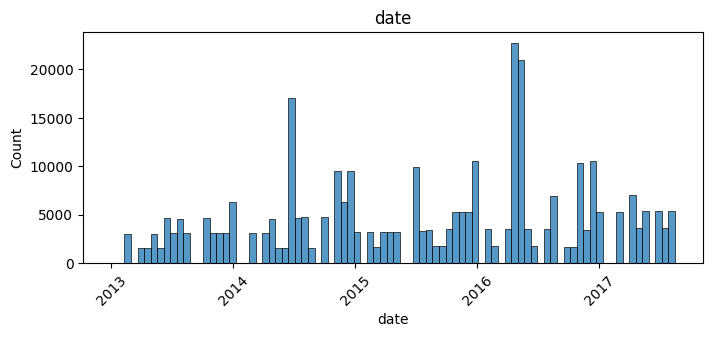

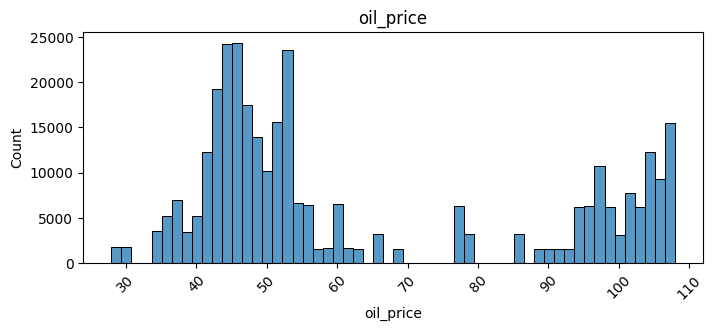

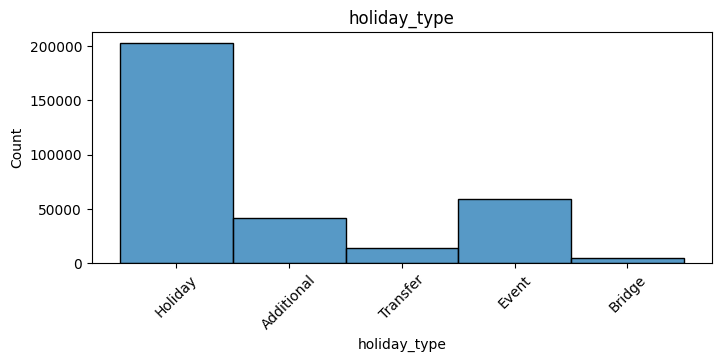

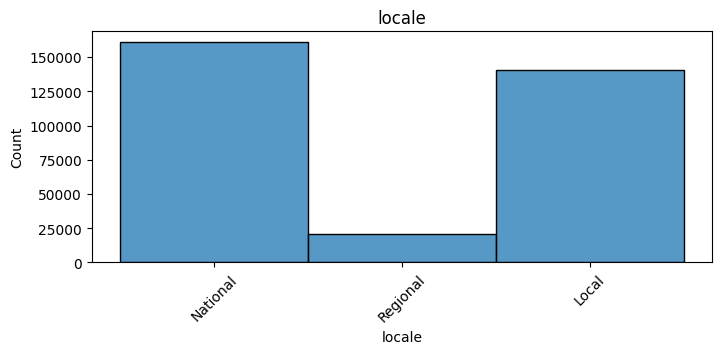

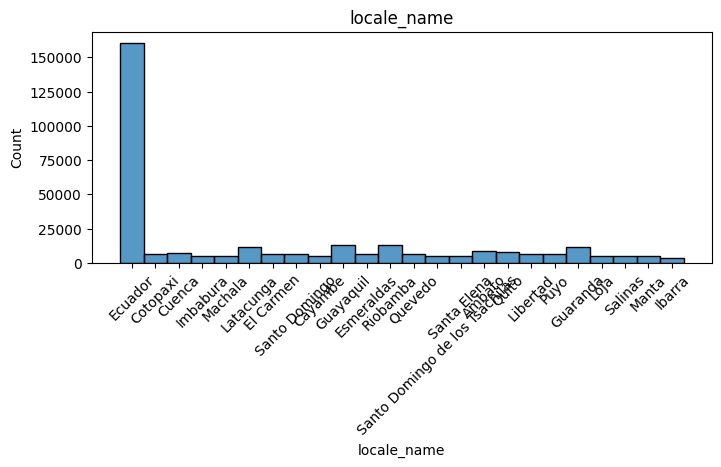

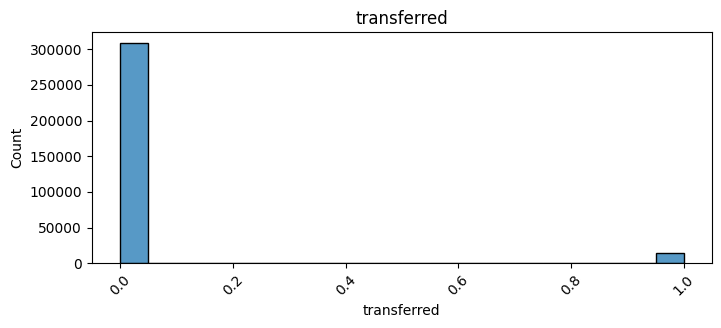

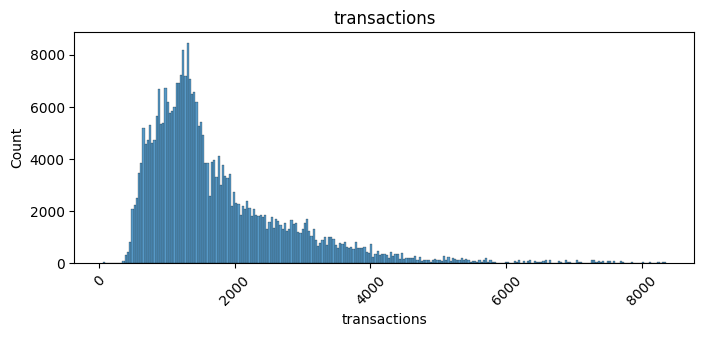

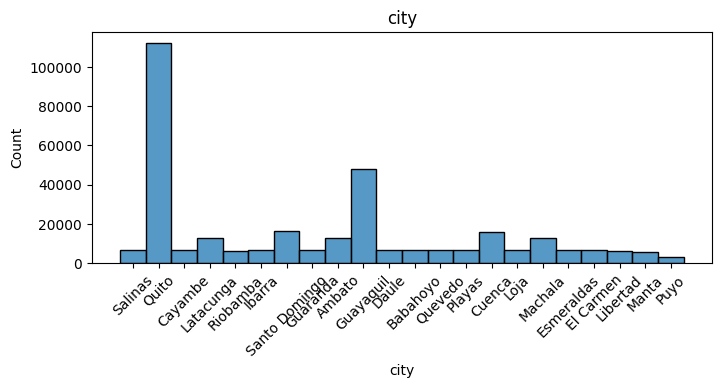

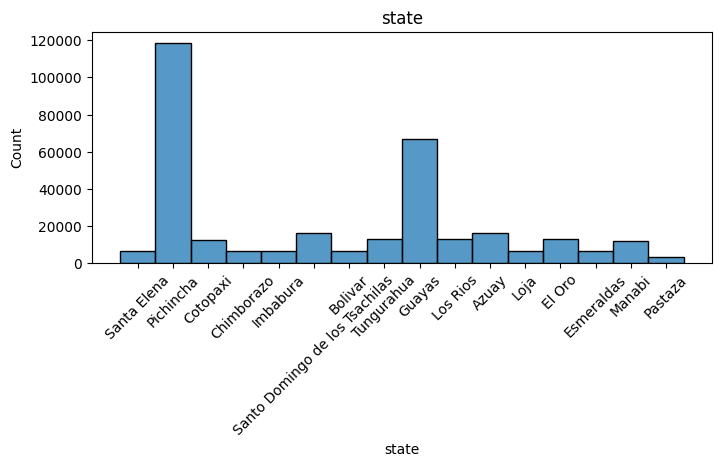

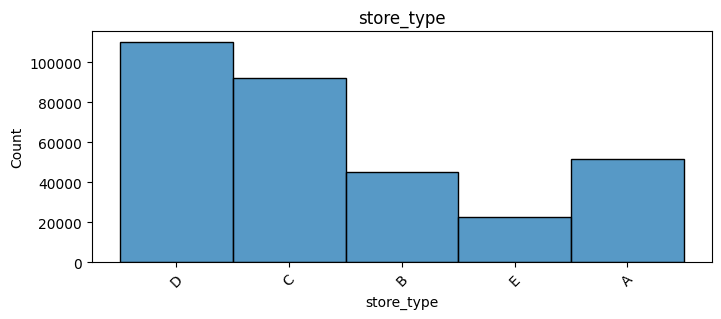

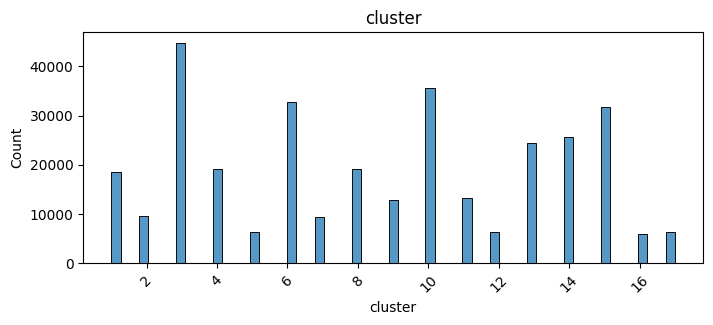

In [29]:
# Draw a boxplot for Sales and onpromotion
for column in all_df.drop(columns=['id','description','store_nbr','sales','onpromotion','family'], axis=1).columns:
    plt.figure(figsize=(8,3))
    sns.histplot(x=column, data=all_df)
    plt.title(f'{column}')
    plt.xticks(rotation=45)
    plt.show()

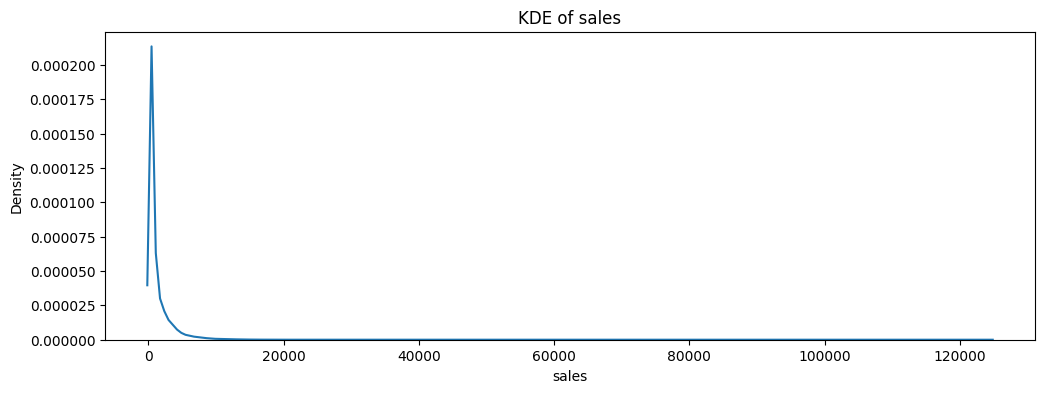

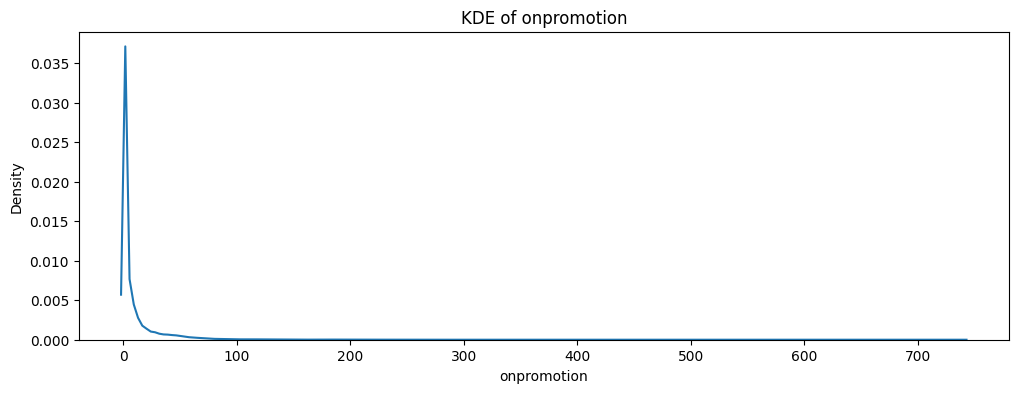

In [30]:
# Draw a kdeplot for Sales and onpromotion
for column in train_df[['sales','onpromotion']].columns:
    plt.figure(figsize=(12,4))
    sns.kdeplot(x=column, data=train_df)
    plt.title(f'KDE of {column}')
    plt.show()

__Key Insights__
- Peak activity is recorded within 2016 (highest) and mid 2014
- For most days oil price ranged between 40 to 50.
-  Most of the data came from the stores in Equador, This could indicate that most of the stores are located in Equador
- On most days the total count of transactions ranges from 1000 t0 2000 transactions
- The distribution of "sales" and "onpromotion" are highly skewed to the right, indicating that sales and promotions were low throughout the year
with the rare events of them being high.
- There wasn't a lot of promotions throughout the years, only a small number of items are on promotion at any given time, and it is rare to have a very high number of items on promotion.
- There were more holiday than any "type' of events
- Only few day "type" (Holiday,event, etc), were actually transferred to another day.
- The city and state with most data is Qinto and Pichincha respectively

#### Multivariate Analysis

In [31]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   oil_price     322047 non-null  float64       
 7   holiday_type  322047 non-null  object        
 8   locale        322047 non-null  object        
 9   locale_name   322047 non-null  object        
 10  description   322047 non-null  object        
 11  transferred   322047 non-null  bool          
 12  transactions  322047 non-null  int64         
 13  city          322047 non-null  object        
 14  state         322047 non-null  object        
 15  store_type    322

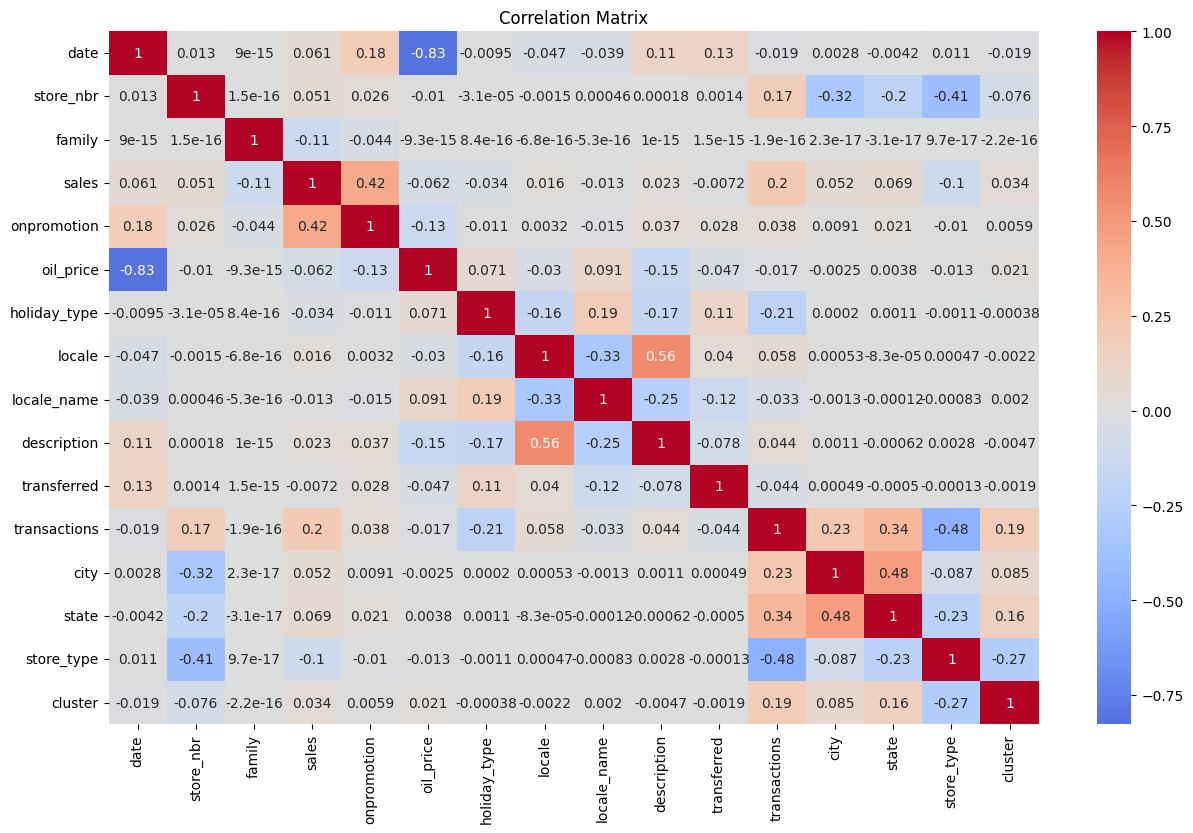

In [32]:
# Copy all_df to all_df1
all_df1 = all_df.copy()

# Convert categorical variables to numerical in order to calculate correlations between all columns
categorical_columns = all_df.select_dtypes(include=['object', 'bool']).columns
for column in categorical_columns:
    all_df1[column] = all_df1[column].astype('category').cat.codes

# Calculate correlation matrix
correlation_matrix = all_df1.drop("id", axis=1).corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(15, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

__Key Insights__
- Strong negative correlation (-0.83) between __'date' and 'dcoilwtico'__ suggests that oil prices may have decreased over time.
- Positive correlation (0.56) between __'locale' and 'description'__ which makes sense. It indicates that certain locales may be associated with specific types of descriptions.
- The moderate positive correlation (0.42) between __'sales' and 'onpromotion'__ suggests that promotional activities may boost sales.
- 'Transactions' has a weak positive correlation (0.2) with both 'sales' and 'store_nbr', which makes sense because as the number of transactions or stores increases, there's a slight tendency for sales to increase as well.
- There are no extremely strong correlations (except for date and dcoilwtico).
- Negative correlation (-0.48) between __'transactions' and 'store_type'__.

#### Check for Stationarity

In [33]:
# Set the "date" column as the index
all_df = all_df.set_index('date')

# Create function to calculate the stationarity of the data at different time_frame
def adf_test1(time_series):
    result = adfuller(time_series, autolag= "AIC")
    print('ADF Statistic: %f' % result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print('The data does not have root unit and is stationary')
    else:
        print('The data has root unit and is non-stationary')

In [34]:
# Insert "sales" into the funtion to determine the stationarity
all_sales = all_df['sales']
adf_test1(all_sales)

ADF Statistic: -36.021872
p-value: 0.0
The data does not have root unit and is stationary


Monthly

In [35]:
# Resample "sales" to monthly means and determine the stationarity
adf_test1(all_df['sales'].resample('M').mean().dropna())

ADF Statistic: -2.607852
p-value: 0.09138524472061427
The data has root unit and is non-stationary


Weekly

In [36]:
# Resample "sales" to monthly means and determine the stationarity
adf_test1(all_df['sales'].resample('W').mean().dropna())

ADF Statistic: -2.490622
p-value: 0.11777286869995651
The data has root unit and is non-stationary


Day

In [37]:
# Resample "sales" to monthly means and determine the stationarity
adf_test1(all_df['sales'].resample('D').mean().dropna())

ADF Statistic: -2.272936
p-value: 0.18084516045157356
The data has root unit and is non-stationary


__Summary__
- When using the original "all_sales" data(Yearly), the ADF test shows that the data is stationary. This could be because the original data has inherent properties that make it stationary, such as a strong mean-reverting pattern or no clear trend over time.
- Resampling the data to monthly, weekly and daily means changes the structure of the data. Monthly averaging can smooth out short-term fluctuations and trends, potentially introducing a trend or other non-stationary characteristics that were not present in the original data.

Using Rolling Statistics to determine the stationarity

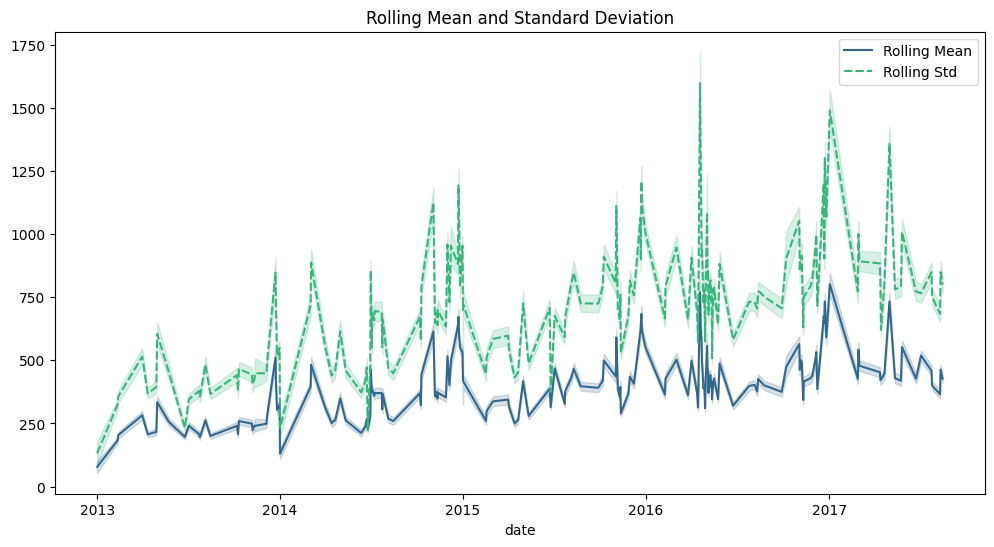

In [38]:
# Calculating the rolling mean and rolling standard deviation
rolling_mean = all_df['sales'].rolling(window=7).mean()
rolling_std = all_df['sales'].rolling(window=7).std()

# Create a DataFrame from the rolling mean and rolling standard deviation
rolling_stats = pd.DataFrame({'Rolling Mean': rolling_mean, 'Rolling Std': rolling_std})

# Plot the rolling_stats
plt.figure(figsize=(12, 6))
sns.lineplot(data=rolling_stats, palette= "viridis")
plt.title("Rolling Mean and Standard Deviation")
plt.show()

__Insight__
- The data is non-stationary, showing both an upward trend in the mean and increasing volatility over time, which violates the constant mean and variance requirements of stationary processes.

#### Hypothesis testing

In [39]:
# Extract relevant variables for Hypothesis testing
sale_onpromo = all_df[all_df['onpromotion'] >= 1][['sales']]
sale_no_promo = all_df[all_df['onpromotion']==0][['sales']]

# Perform a two sample t-test to compare sales of product on promotion and with no promotion pip install scipy
t_statistic, p_value = ttest_ind(sale_onpromo, sale_no_promo)

# Print result
print("Test Statistic:", t_statistic)
print("P-value:", p_value)
print('-'*50)
if p_value < 0.05:
    print("Reject the null hypothesis.")
    print("There is a significant difference in sales between product on promotion and with no promotion.")
    print("Promotions have a significant impact on sales")
else:
    print("Fail to reject the null hypothesis.")
    print("There is no significant difference in sales between product on promotion and with no promotion.")
    print("Promotions have no a significant impact on sales")
    

Test Statistic: [208.39559359]
P-value: [0.]
--------------------------------------------------
Reject the null hypothesis.
There is a significant difference in sales between product on promotion and with no promotion.
Promotions have a significant impact on sales


In [40]:
all_df[all_df['onpromotion'] >= 1].shape

(83451, 16)

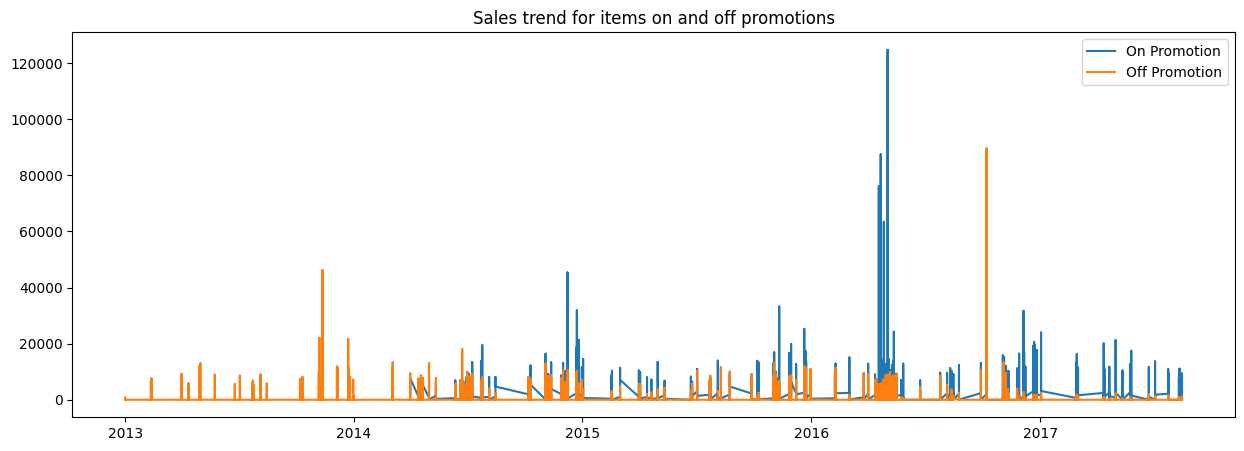

In [41]:
# Plot sales trend over time for items on and not on promotion
plt.figure(figsize=(15,5))
plt.plot(all_df[all_df['onpromotion'] >= 1].index, sale_onpromo, label= 'On Promotion')
plt.plot(all_df[all_df['onpromotion']==0].index, sale_no_promo, label= 'Off Promotion')
plt.title("Sales trend for items on and off promotions")
plt.legend()


__Key Insights__
- Items on promotion generally show higher sales spikes compared to not on promotion items. This suggests that promotions are effective in driving sales, with several notable peaks far exceeding the baseline sales levels.
- The sales exhibit recurring spikes, likely indicating seasonal trends. These peaks appear more pronounced towards the end of each year, possibly corresponding to holiday shopping seasons. The pattern is consistent across the years,

#### Answering Analytical Questions
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.


##### 1. Is the train dataset complete (has all the required dates)? 

In [42]:
# Checking the minimum and maximum dates for training data
min_date = train_df['date'].min()
max_date = train_df['date'].max()

# Calculate the expected number of days
expected_days = pd.date_range(start=min_date, end=max_date, freq= 'D')
actual_days = train_df['date'].unique()

print(f'With the expected number of days being {len(expected_days)} days, \nthe data has actual number of days to be {len(actual_days)} days,\nwhich is {len(expected_days) - len(actual_days)} days behind the expected.')


With the expected number of days being 1688 days, 
the data has actual number of days to be 1684 days,
which is 4 days behind the expected.


In [43]:
# Find missing dates
missing_dates = expected_days.difference(actual_days).to_list()
print("missing dates:")
missing_dates

missing dates:


[Timestamp('2013-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-12-25 00:00:00')]

##### 2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)? 

In [44]:
# Extract year, months, month name and days from the train data
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['month_name'] = train_df['date'].dt.month_name()
train_df['day'] = train_df['date'].dt.day

# Print results
train_df.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,month_name,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,January,1
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,January,1
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,January,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,January,1
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,January,1


Highest Sales by date

              date  year       sales
562596  2013-11-12  2013   46271.000
1257246 2014-12-08  2014   45361.000
1916586 2015-12-14  2015   40351.460
2163723 2016-05-02  2016  124717.000
2760297 2017-04-02  2017   38422.625


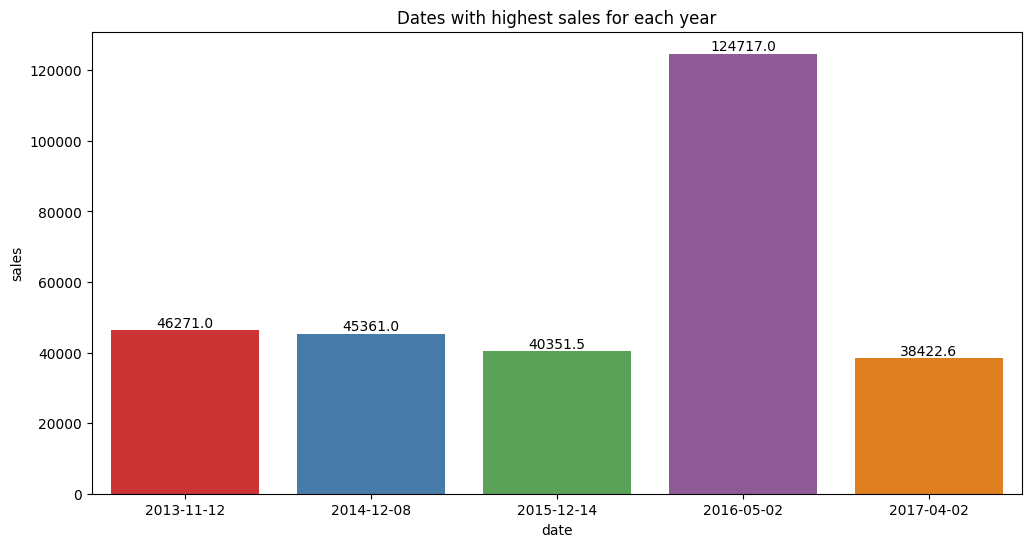

In [45]:
# Sort the data with respect to the sales
desc_train_df = train_df.sort_values(by='sales', ascending=False)

# Find the id of first sale by year
max_sales= desc_train_df.groupby(by='year').sales.idxmax()

# Locate the data in the train_df using their id
yearly_max_sales= train_df.iloc[max_sales]

# print results
print(yearly_max_sales[['date','year','sales']])

# Visualze the highest sales for each year with specific date
plt.figure(figsize=(12,6))
sns.barplot(data=yearly_max_sales, x="date", y="sales", palette='Set1')
plt.title('Dates with highest sales for each year')
for index, value in enumerate(yearly_max_sales['sales']):
    label = f'{value:.1f}'
    plt.text(index, value, label, ha= 'center', va='bottom')
plt.show()

___

Lowest Sales by date

              date  year  sales
387782  2013-08-06  2013  0.122
1252052 2014-12-05  2014  0.188
1756358 2015-09-15  2015  0.196
2256638 2016-06-23  2016  0.396
2666498 2017-02-09  2017  0.426


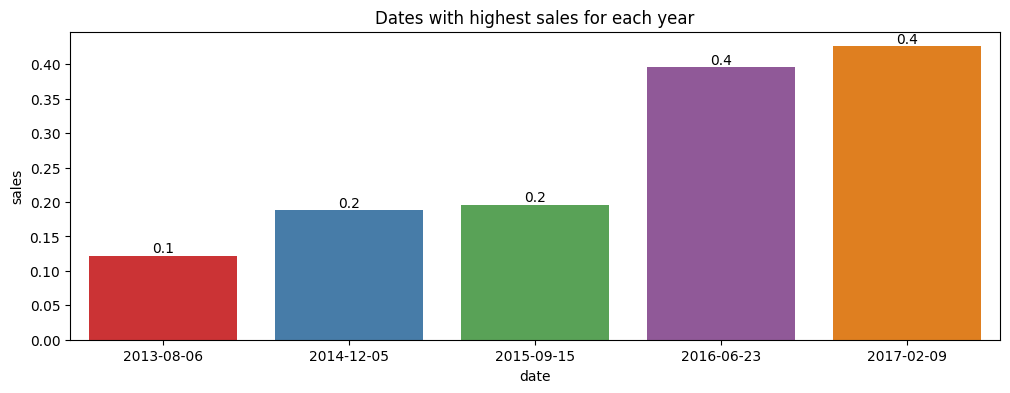

In [46]:
# Sort the data with respect to the sales(descending order) and remove closed stores
asc_train_df = train_df[train_df['sales']>0].sort_values(by='sales', ascending=True)

# Find the id of first sale by year
min_sales= asc_train_df.groupby(by='year').sales.idxmin()

# Locate the data in the train_df using their id
yearly_min_sales= asc_train_df.loc[min_sales]

# print results
print(yearly_min_sales[['date','year','sales']])

# Visualze the lowest sales for each year with specific date
plt.figure(figsize=(12,4))
sns.barplot(data=yearly_min_sales, x="date", y="sales", palette='Set1')
plt.title('Dates with highest sales for each year')
for index, value in enumerate(yearly_min_sales['sales']):
    label = f'{value:.1f}'
    plt.text(index, value, label, ha= 'center', va='bottom')
plt.show()


##### 3. Compare the sales for each month across the years and determine which month of which year had the highest sales.

In [47]:
# Calculate monthly sales for each year
year_2013 = train_df[train_df['year']==2013].groupby(by=["month",'month_name']).sales.sum()/1000000
year_2014 = train_df[train_df['year']==2014].groupby(by=["month",'month_name']).sales.sum()/1000000
year_2015 = train_df[train_df['year']==2015].groupby(by=["month",'month_name']).sales.sum()/1000000
year_2016 = train_df[train_df['year']==2016].groupby(by=["month",'month_name']).sales.sum()/1000000
year_2017 = train_df[train_df['year']==2017].groupby(by=["month",'month_name']).sales.sum()/1000000

#Create a DataFrame for the sum of months
all_years = pd.DataFrame({"2013":year_2013, "2014":year_2014, "2015":year_2015, "2016":year_2016, "2017":year_2017})

# Print results
all_years

,,2013,2014,2015,2016,2017
month,month_name,,,,,
1,January,10.327625,18.911641,14.896922,23.977805,26.328160
2,February,9.658960,12.038353,13.742396,21.947409,23.250112
3,March,11.428497,20.365584,15.598608,23.131781,26.704018
4,April,10.993465,12.861251,14.955068,25.963025,25.895308
5,May,11.597704,13.379785,17.730368,24.779432,26.911847
6,June,11.689344,13.319958,21.615360,22.209219,25.682822
7,July,11.257401,19.421891,22.209619,23.462672,27.011478
8,August,11.737789,13.885176,22.963674,22.452414,12.433323
9,September,11.792933,20.022416,23.240882,22.417448,NaN



The highest sale of 29.6M happened on December 2016


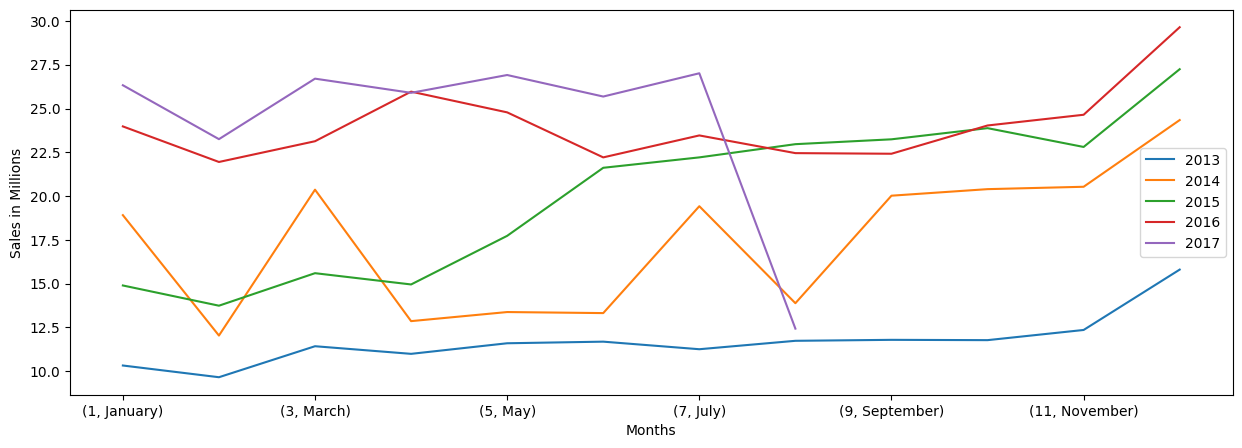

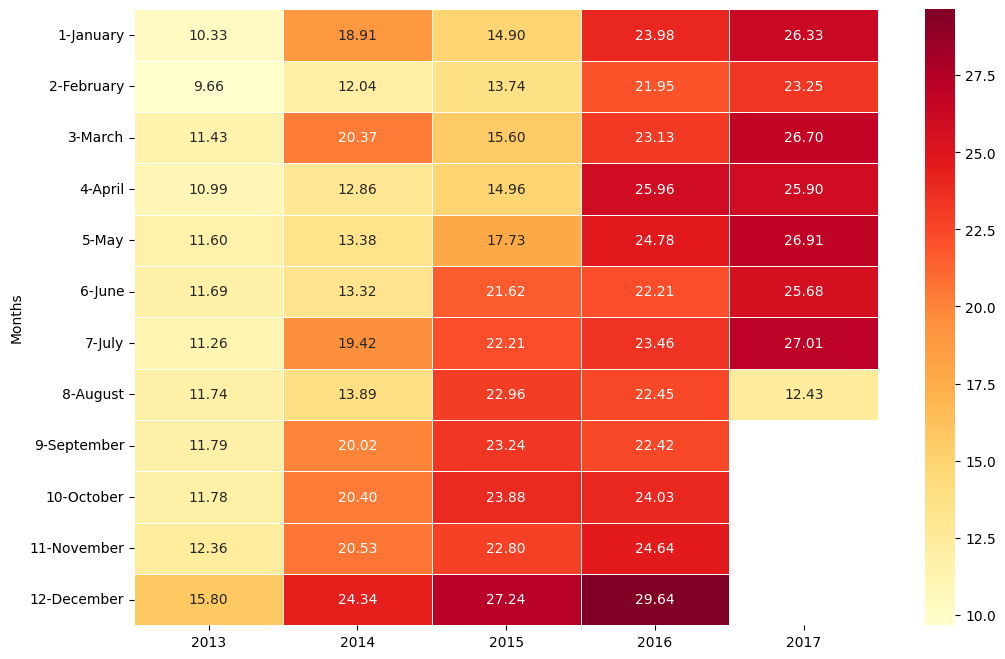

In [48]:
# Calculating for the maximum sales and it's year and month
max_sales = all_years.max().max()
max_month = all_years.max().idxmax()
max_year = all_years.max(axis=1).idxmax()

# Print result
print(f'\nThe highest sale of {max_sales:,.1f}M happened on {max_year[1]} {max_month}')

# Comparing the years across the months
all_years.plot(kind='line', figsize=(15,5), xlabel='Months', ylabel='Sales in Millions')

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(all_years, annot=True, fmt='.2f', cmap='YlOrRd', linewidths=0.5)
plt.ylabel('Months')
plt.show()


##### 4. Did the earthquake impact sales?

A 7.8 magnitude earthquake hit Ecuador on April 16, 2016. In response, people mobilized for relief efforts donating water and other essential items, which significantly impacted supermarket sales for several weeks following the disaster.

In [49]:
# Set the date column as the index
train_df.set_index('date', inplace=True)

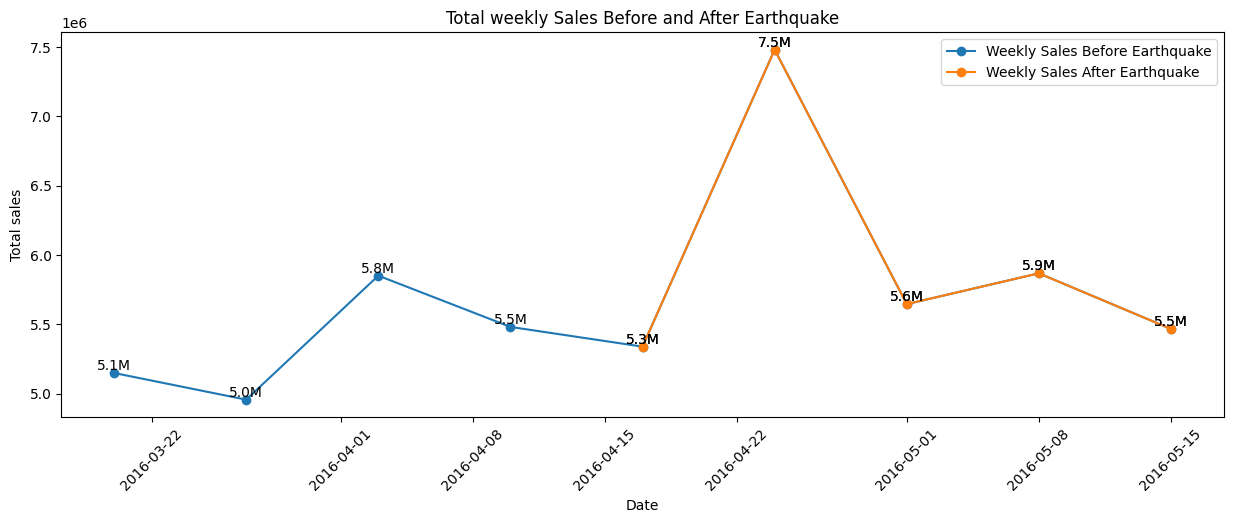

In [50]:
# Weekly frequency
weekly_sales = train_df['sales'].resample('W').sum()

# Date before,after and end of earthquake
start = '2016-03-16'
after = '2016-04-16'
end = '2016-05-16'

# Sales data before and after earthquake
sales_before = weekly_sales.loc[start:end]
sales_after = weekly_sales.loc[after:end]

# plotting data of sales before and after eathquake
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(sales_before, label='Weekly Sales Before Earthquake', marker= 'o')
ax.plot(sales_after, label='Weekly Sales After Earthquake', marker= 'o')

ax.legend()
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel('Total sales')
ax.set_xlabel("Date")
ax.set_title("Total weekly Sales Before and After Earthquake")
# Annotating data points
for index, value in enumerate(sales_before):
    plt.text(sales_before.index[index], value, f'{value/1000000:.1f}M', ha='center', va='bottom')
for index, value in enumerate(sales_after):
    plt.text(sales_after.index[index], value, f'{value/1000000:.1f}M', ha='center', va='bottom')

plt.show()

__Observations__
- The sales sharply drop right after the earthquake, indicating a significant immediate impact on sales.
- There is a noticeable spike in sales following the initial drop, with the peak reaching around 7.5 million. This peak may suggest recovery efforts, increased demand for essential goods, or other factors driving sales up post-earthquake.
- After the spike, the sales gradually decline but remain above the pre-earthquake levels. The sales did not return to the previous baseline level, possibly indicating a lasting change in the market conditions or consumer behavior.

##### 5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

In [51]:
# Merge the stores data with train data
train_stores_df = pd.merge(train_df, stores_df, on='store_nbr')
print(train_stores_df.shape)
train_stores_df.head()

(3000888, 13)


,id,store_nbr,family,sales,onpromotion,year,month,month_name,day,city,state,type,cluster
0,0,1,AUTOMOTIVE,0.0,0,2013,1,January,1,Quito,Pichincha,D,13
1,1,1,BABY CARE,0.0,0,2013,1,January,1,Quito,Pichincha,D,13
2,2,1,BEAUTY,0.0,0,2013,1,January,1,Quito,Pichincha,D,13
3,3,1,BEVERAGES,0.0,0,2013,1,January,1,Quito,Pichincha,D,13
4,4,1,BOOKS,0.0,0,2013,1,January,1,Quito,Pichincha,D,13


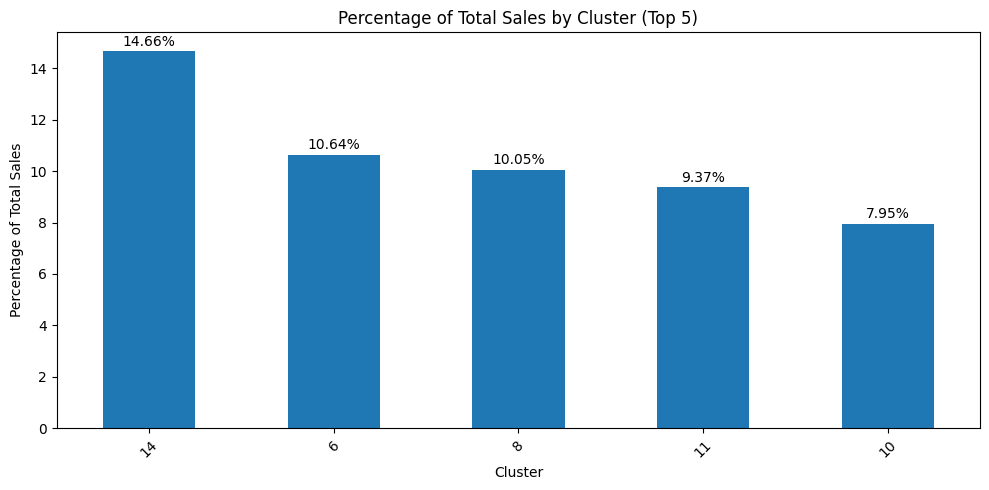

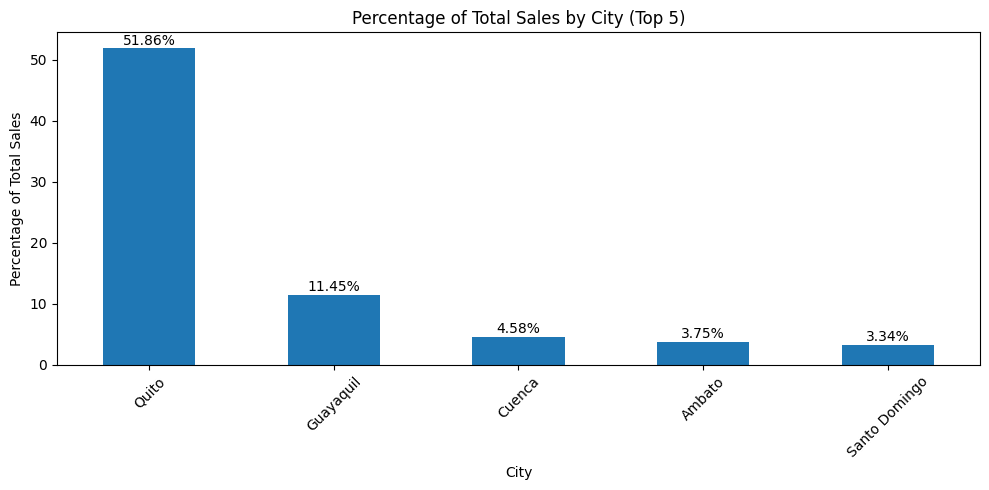

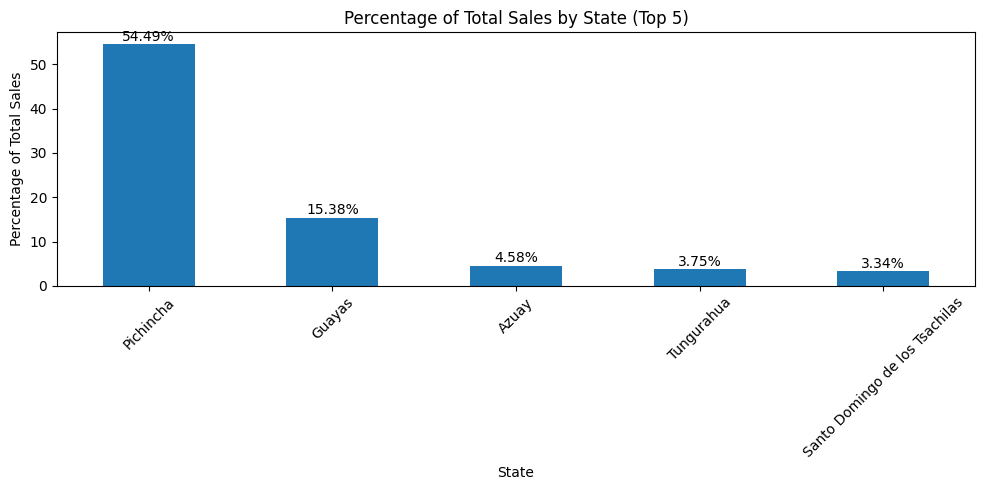

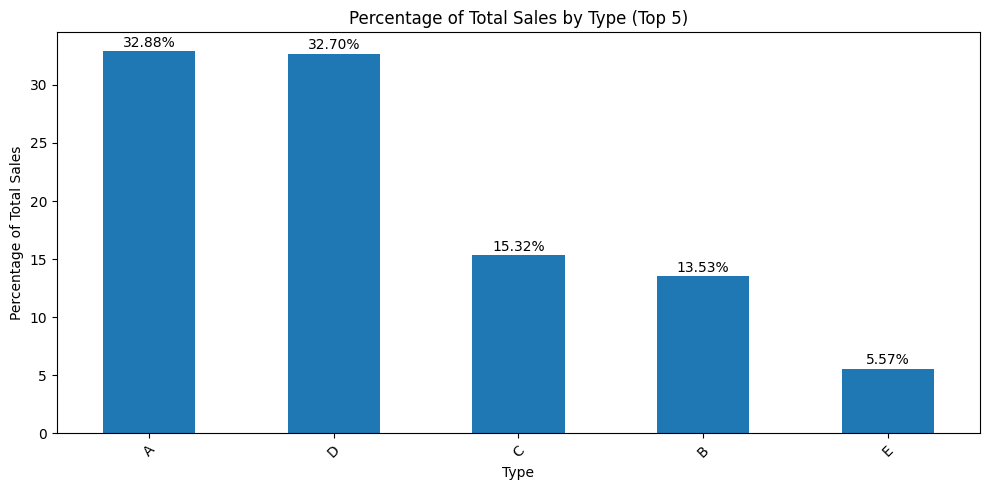

In [52]:
# Calculate total sales by cluster, city, state, and type
cluster_sales = train_stores_df.groupby('cluster').sales.sum().sort_values(ascending=False).head()
city_sales = train_stores_df.groupby('city').sales.sum().sort_values(ascending=False).head()
state_sales = train_stores_df.groupby('state').sales.sum().sort_values(ascending=False).head()
type_sales = train_stores_df.groupby('type').sales.sum().sort_values(ascending=False).head()

# Calculate the overall total sales
total_sales = train_stores_df.sales.sum()

# Calculate the percentage sales for each cluster, city, state, and type
cluster_percentage_sales = (cluster_sales / total_sales) * 100
city_percentage_sales = (city_sales / total_sales) * 100
state_percentage_sales = (state_sales / total_sales) * 100
type_percentage_sales = (type_sales / total_sales) * 100

# Place the percentages in a dictionary
percentages = {
    'Cluster': cluster_percentage_sales,
    'City': city_percentage_sales,
    'State': state_percentage_sales,
    'Type': type_percentage_sales
}

# Visualize the bar plot for each category
for category, percentage_data in percentages.items():
    plt.figure(figsize=(10, 5))
    percentage_data.plot.bar()
    
    # Add labels to the bars
    for i, value in enumerate(percentage_data):
        plt.text(i, value + 0.1, f'{value:.2f}%', ha='center', va='bottom')
        
    plt.title(f'Percentage of Total Sales by {category} (Top 5)')
    plt.xlabel(category)
    plt.ylabel('Percentage of Total Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


__Observation__
- Cluster 14 has the highest sales, accounting for approximately 14%  of the total sales.
- Pichincha state and Quinto city has the highest sales with approximately 54.4% and 51.8% of the total sales respectively.
- Store type A and D has the highest sales of approximately 32.8% and 32.7% of the total sales respectively.

##### 6. Are sales affected by promotions, oil prices and holidays?

By Promotions

In [53]:
# Set date as index
train_df.head()

,id,store_nbr,family,sales,onpromotion,year,month,month_name,day
date,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,2013,1,January,1
2013-01-01,1,1,BABY CARE,0.0,0,2013,1,January,1
2013-01-01,2,1,BEAUTY,0.0,0,2013,1,January,1
2013-01-01,3,1,BEVERAGES,0.0,0,2013,1,January,1
2013-01-01,4,1,BOOKS,0.0,0,2013,1,January,1


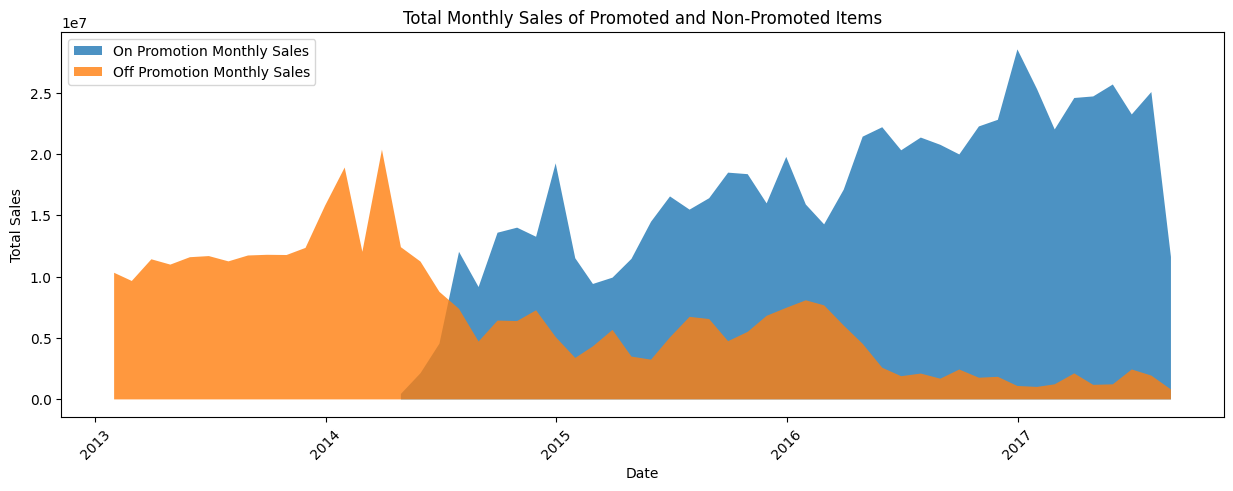

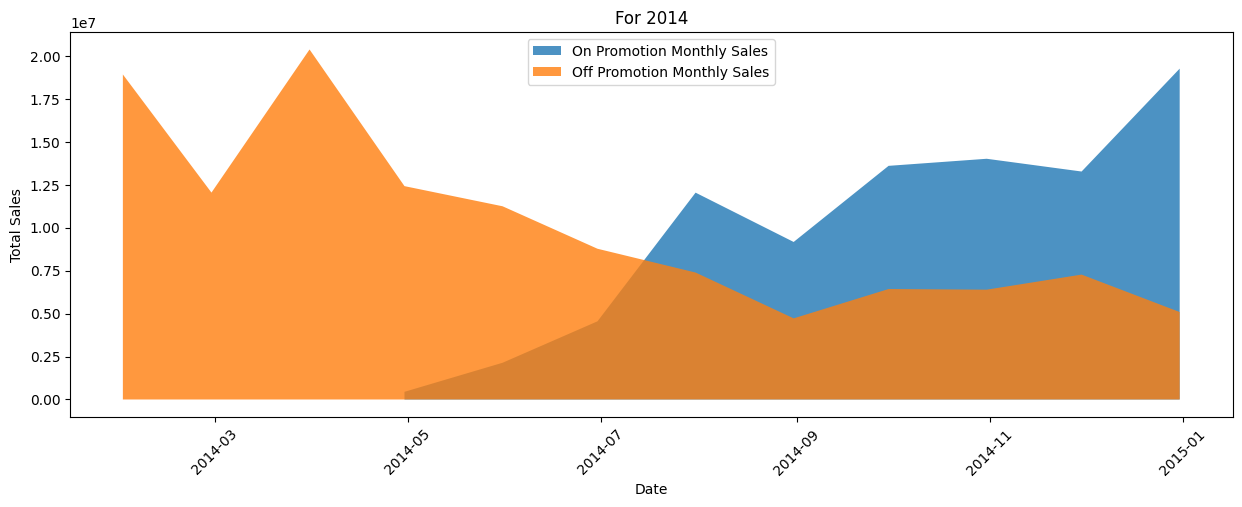

In [54]:
# Calculate the Monthly sum of sales for items on promotion and off promotion
on_promotions = train_df[train_df.onpromotion>0].sales.resample('M').sum()
not_on_promotions = train_df[train_df.onpromotion==0].sales.resample('M').sum()

# Plotting data of weekly on promotion sales and off promotion sales as an area plot
fig, ax = plt.subplots(figsize=(15, 5))

ax.fill_between(on_promotions.index, on_promotions, label='On Promotion Monthly Sales', alpha=0.8)
ax.fill_between(not_on_promotions.index, not_on_promotions, label='Off Promotion Monthly Sales', alpha=0.8)

ax.legend()
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel('Total Sales')
ax.set_xlabel("Date")
ax.set_title("Total Monthly Sales of Promoted and Non-Promoted Items")
plt.show()

# =================================================================

# Calculate the Monthly sum of sales for items on promotion and off promotion in 2014
on_promotions_2014 = train_df[(train_df.onpromotion>0) & (train_df.year==2014)].sales.resample('M').sum()
not_on_promotions_2014 = train_df[(train_df.onpromotion==0) & (train_df.year==2014)].sales.resample('M').sum()

# Plotting data of weekly on promotion sales and off promotion sales as an area plot
fig, ax = plt.subplots(figsize=(15, 5))

ax.fill_between(on_promotions_2014.index, on_promotions_2014, label='On Promotion Monthly Sales', alpha=0.8)
ax.fill_between(not_on_promotions_2014.index, not_on_promotions_2014, label='Off Promotion Monthly Sales', alpha=0.8)

ax.legend()
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel('Total Sales')
ax.set_xlabel("Date")
ax.set_title("For 2014")
plt.show()



__Observation__
- We clearly see that from graph that as the years went by promotion had increasing positive impact on sales.
- Promotions of products begun in May 2014.


By Oil Price

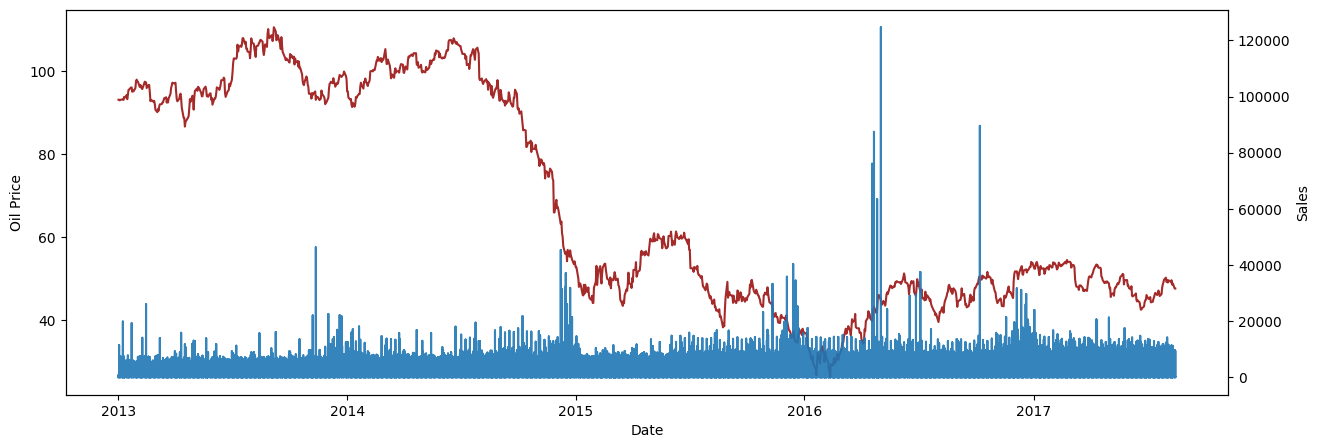

Correlation between oil_price and sales: -0.08


In [55]:
# Merge train data with oil and holiday data
train_oil = train_df.merge(oil_df, on="date")

# Plotting data of weekly on promotion sales and off promotion sales as an area plot
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(train_oil.date, train_oil.oil_price, label='oil_price', color= 'brown')
ax.set_xlabel('Date')
ax.set_ylabel('Oil Price')

ax2 = ax.twinx()
ax2.plot(train_oil.date, train_oil.sales, label='sales', alpha=0.9)
ax2. set_xlabel('Date')
ax2.set_ylabel('Sales')
plt.show()

# Calculate the correlation between oi_price and sales
oil_sales_correlation = np.corrcoef(train_oil.oil_price, train_oil.sales)

# Print result
print(f"Correlation between oil_price and sales: {oil_sales_correlation[0, 1]:.2f}")

__Observation__
- We observe a very weak inverse relationship between oil prices and sales. This suggests that changes in oil prices have little to no impact on sales.

By Holidays

In [56]:
# Merge train_df and holidays_df
train_holidays = train_df.merge(holidays_df, on='date')

train_holidays.head()

,date,id,store_nbr,family,sales,onpromotion,year,month,month_name,day,type,locale,locale_name,description,transferred
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,2013,1,January,1,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,1,1,BABY CARE,0.0,0,2013,1,January,1,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,2,1,BEAUTY,0.0,0,2013,1,January,1,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,3,1,BEVERAGES,0.0,0,2013,1,January,1,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,4,1,BOOKS,0.0,0,2013,1,January,1,Holiday,National,Ecuador,Primer dia del ano,False


In [57]:
# Find the type across the dataset
train_holidays.type.value_counts()

type
Holiday       304722
Event          99792
Additional     67716
Transfer       16038
Work Day        8910
Bridge          5346
Name: count, dtype: int64

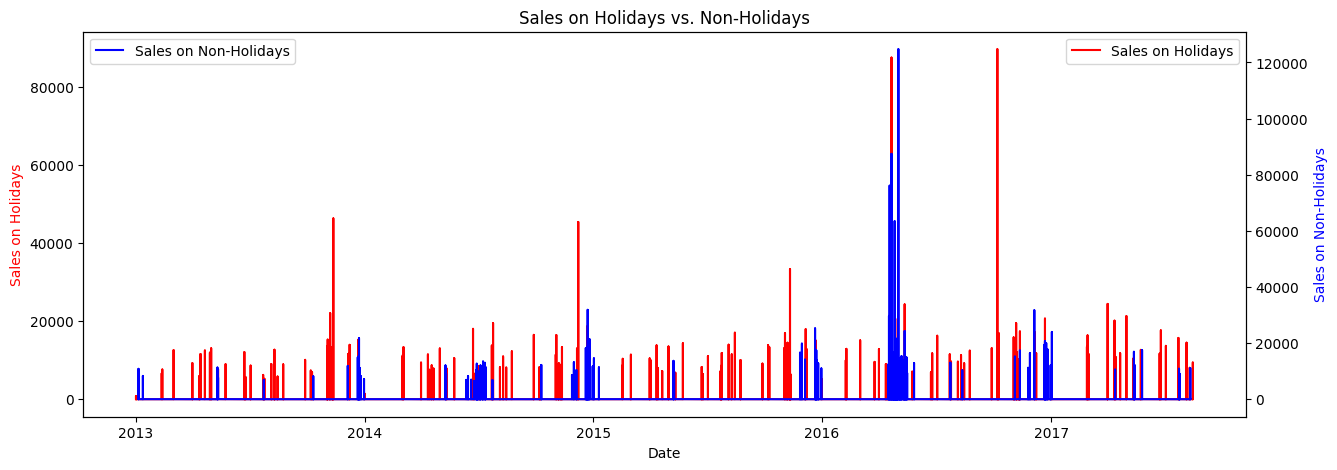

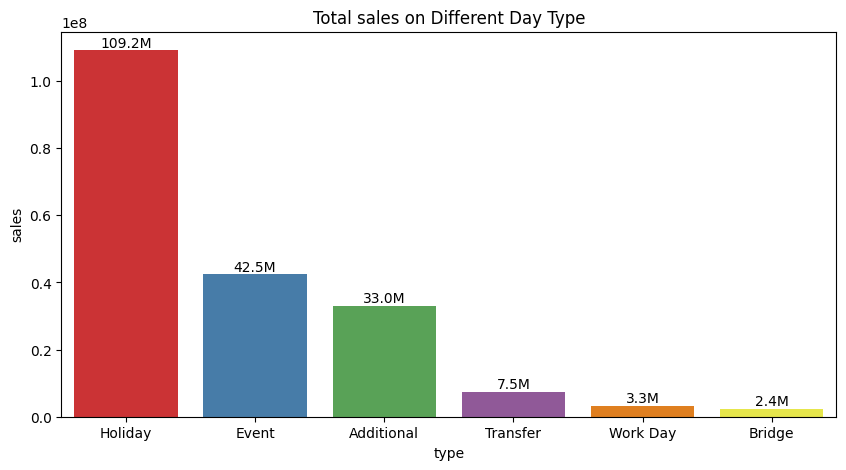

In [58]:
# Filter sales on holidays and non-holidays
sales_on_holidays = train_holidays[train_holidays['type'] == "Holiday"]
sales_non_holidays = train_holidays[train_holidays['type'] != "Holiday"]

# Plot graph
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot sales on holidays
ax1.plot(sales_on_holidays.date, sales_on_holidays.sales, label='Sales on Holidays', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales on Holidays', color='red')
ax1.legend()

# Create a second y-axis and plot sales on non-holidays
ax2 = ax1.twinx()
ax2.plot(sales_non_holidays.date, sales_non_holidays.sales, label='Sales on Non-Holidays', color='blue')
ax2.set_ylabel('Sales on Non-Holidays', color='blue')

# Show plot
plt.title('Sales on Holidays vs. Non-Holidays')
plt.legend(loc='upper left')
plt.show()


# =================================================================
# Visualize sales on different day type
holiday_type = train_holidays.groupby('type').sales.sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(holiday_type, palette='Set1')
plt.title('Total sales on Different Day Type')
for index, value in enumerate(holiday_type):
    label = f'{value/1000000:.1f}M'
    plt.text(index, value, label, ha= 'center', va='bottom')
plt.show()



__Observation__
- The red bars representing sales on holidays show significant spikes compared to non-holidays. This indicates that sales tend to increase notably on certain holidays.
- There are more sales on holidays than non-holidays.
- The visual correlation between the two lines suggests that while non-holiday sales are generally lower and steadier, they can be affected by surrounding holidays or events, possibly due to preparatory shopping or post-holiday returns.

##### 7. What analysis can we get from the date and its extractable features?

Total Yearly Sales

In [59]:
month_order = [
    "January", "February", "March", "April",
    "May", "June", "July", "August",
    "September", "October", "November", "December"]

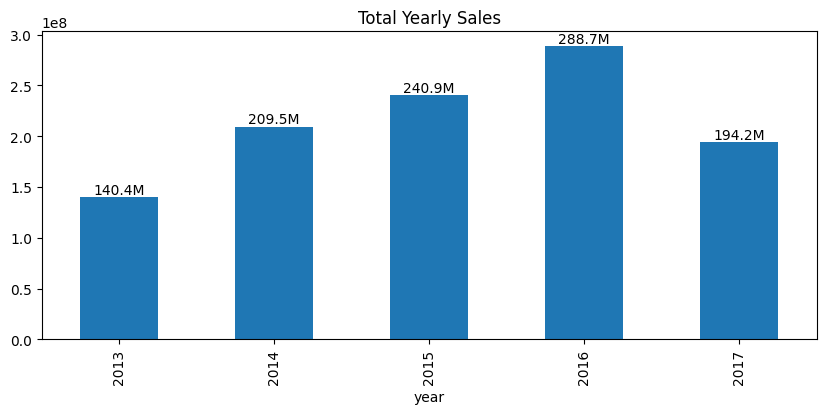

In [60]:
# Total Yearly Sales
total_yearly_sales= train_df.groupby('year').sales.sum()
plt.figure(figsize=(10,4))
total_yearly_sales.plot(kind= 'bar')
plt.title('Total Yearly Sales')

for index, value in enumerate(total_yearly_sales):
    label = f'{value/1000000:.1f}M'
    plt.text(index, value, label, ha= 'center', va='bottom')
plt.show()

Total Monthly Sales

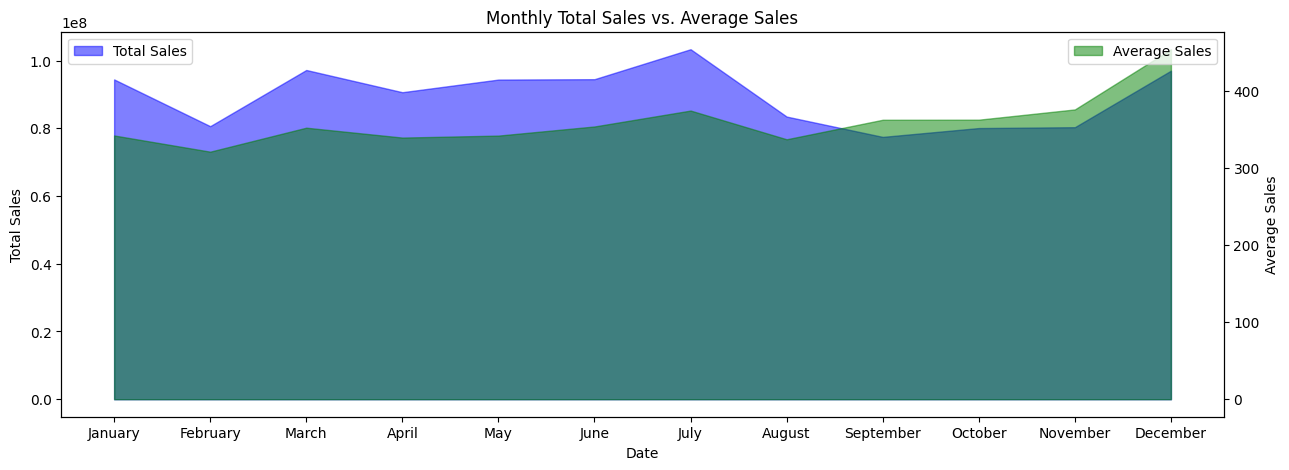

In [61]:
# Define the correct order for the months
month_order = [
    "January", "February", "March", "April", "May", "June", 
    "July", "August", "September", "October", "November", "December"]

# Total Monthly Sales
total_monthly_sales = train_df.groupby(by='month_name').sales.sum().reindex(month_order)

# Total Average Monthly Sales
avg_monthly_sales = train_df.groupby(by='month_name').sales.mean().reindex(month_order)

# Plotting data of weekly on promotion sales and off promotion sales as an area plot
fig, ax = plt.subplots(figsize=(15, 5))

# Plotting Total Sales as an area plot
ax.fill_between(total_monthly_sales.index, total_monthly_sales, label='Total Sales', alpha=0.5, color='blue')
ax.set_ylabel('Total Sales')
ax.set_xlabel('Date')
ax.legend(loc='upper left')

# Plotting Average Sales on the secondary y-axis
ax2 = ax.twinx()
ax2.fill_between(avg_monthly_sales.index, avg_monthly_sales, label='Average Sales', alpha=0.5, color='green')
ax2.set_ylabel('Average Sales')
ax2.legend(loc='upper right')

plt.title('Monthly Total Sales vs. Average Sales')
plt.show()


By Day

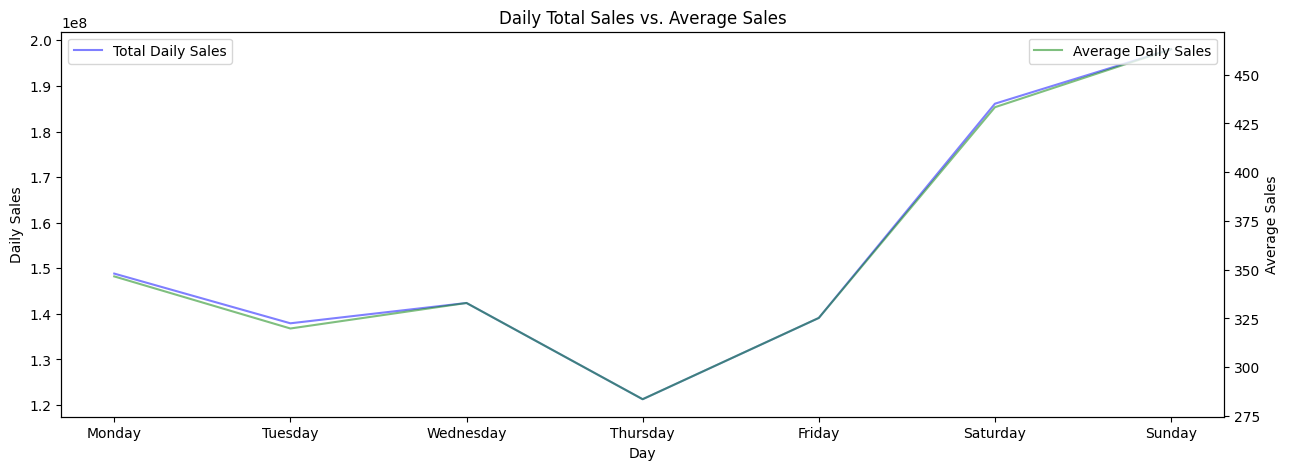

In [62]:
# Extract day name to data
train_df['day_name'] = train_df.index.day_name()

# Day order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Total Daily Sales
total_daily_sales = train_df.groupby(by='day_name').sales.sum().reindex(day_order)

# Average Daily Sales
avg_daily_sales = train_df.groupby(by='day_name').sales.mean().reindex(day_order)

# Plotting figsize
fig, ax = plt.subplots(figsize=(15, 5))

# Plotting Total Daily Sales as an area plot
ax.plot(total_daily_sales.index, total_daily_sales, label='Total Daily Sales', alpha=0.5, color='blue')
ax.set_ylabel('Daily Sales')
ax.set_xlabel('Day')
ax.legend(loc='upper left')

# Plotting Average Daily Sales on the secondary y-axis
ax2 = ax.twinx()
ax2.plot(avg_daily_sales.index, avg_daily_sales, label='Average Daily Sales', alpha=0.5, color='green')
ax2.set_ylabel('Average Sales')
ax2.legend(loc='upper right')

plt.title('Daily Total Sales vs. Average Sales')
plt.show()

By Day number

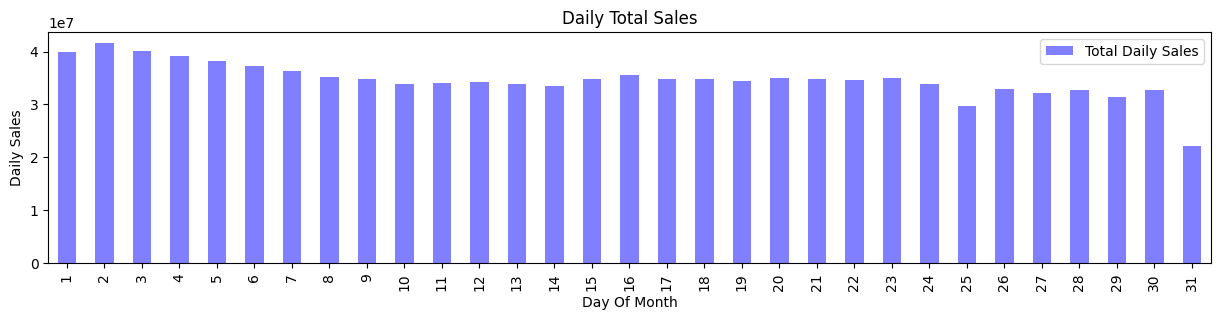

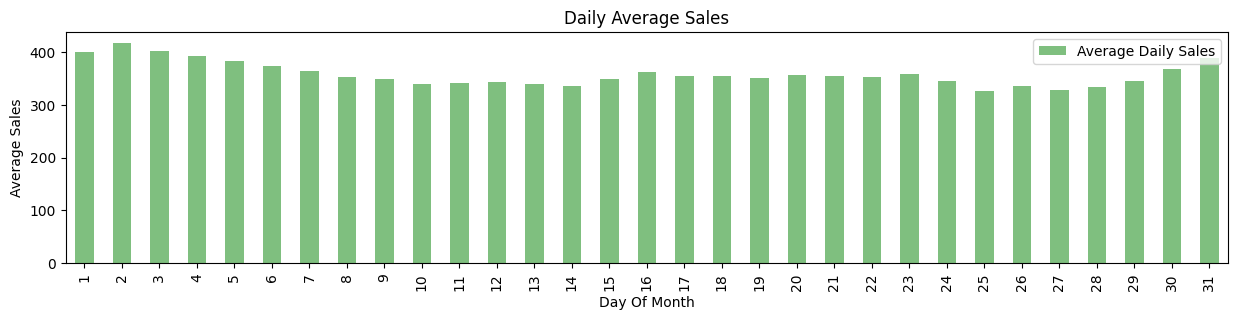

In [63]:
# Total Daily Sales
total_daily_num_sales = train_df.groupby(by='day').sales.sum()

# Average Daily Sales
avg_daily_num_sales = train_df.groupby(by='day').sales.mean()

# Plotting Total Daily Sales as an area plot
plt.figure(figsize=(15, 3))
total_daily_num_sales.plot(kind='bar', label='Total Daily Sales', alpha=0.5, color='blue')
plt.ylabel('Daily Sales')
plt.xlabel('Day Of Month')
plt.legend(loc='upper left')
plt.title('Daily Total Sales')
plt.legend(loc='upper right')
plt.show()

# Plotting Average Daily Sales on the secondary y-axis
plt.figure(figsize=(15, 3))
avg_daily_num_sales.plot(kind='bar', label='Average Daily Sales', alpha=0.5, color='green')
plt.ylabel('Average Sales')
plt.xlabel('Day Of Month')
plt.legend(loc='upper right')
plt.title('Daily Average Sales')
plt.show()

##### 8. Which product family and stores did the promotions affect.
- Keep in mind that promotions begun on May 2014, so sales comparisons will be taken starting from that date.

In [64]:
# Group train data by onpromotion
all_promotions= train_df[train_df['onpromotion']>0].loc['2014-05-01':]
no_promotions= train_df[train_df['onpromotion']==0].loc['2014-05-01':]


Product Family

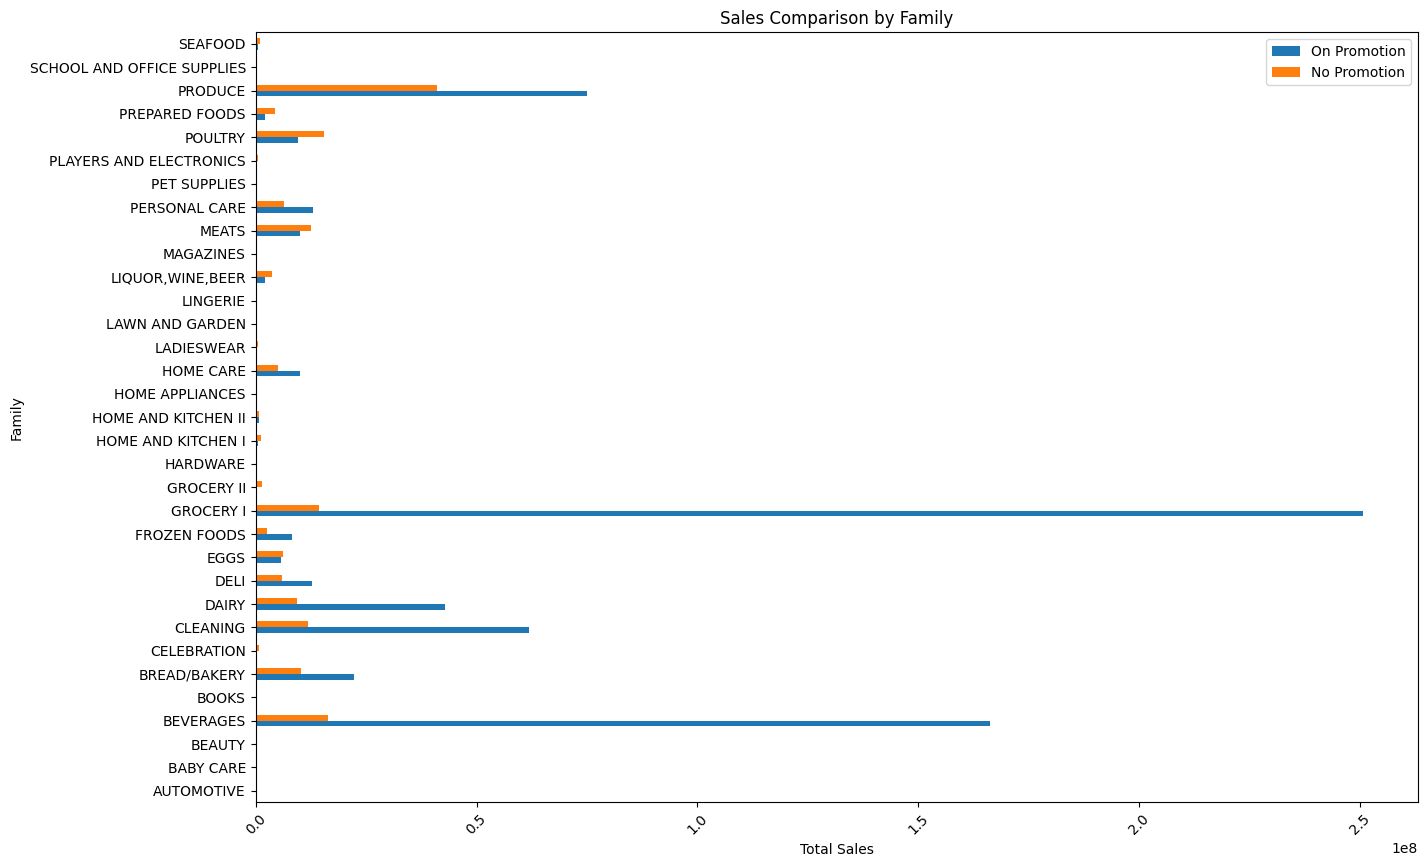

12 products which was 36% of all products in the stores had significant increase in sales when promoted

Products: Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI',
       'FROZEN FOODS', 'GROCERY I', 'HOME AND KITCHEN II', 'HOME CARE',
       'PERSONAL CARE', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES'],
      dtype='object', name='family')


In [65]:
# Group product family by onpromotion or no promotion
onpromo_sales_family = all_promotions.groupby(by='family').sales.sum().sort_values(ascending=False)
nopromo_sales_family = no_promotions.groupby(by='family').sales.sum().sort_values(ascending=False)

# Create a DataFrame for plotting
family_df = pd.DataFrame({
    'On Promotion': onpromo_sales_family,
    'No Promotion': nopromo_sales_family
}).fillna(0)

# Plotting
family_df.plot(kind='barh', figsize=(15, 10))
plt.title('Sales Comparison by Family')
plt.ylabel('Family')
plt.xlabel('Total Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.legend(loc='best')
plt.show()

# =================================================================

# Calculate the difference in sale by products when promoted and when not
promo_diff = family_df['On Promotion'] - family_df['No Promotion']

# Calculate the percentage of sales on promotion
family_df["percentage_on_promotion"] = ((promo_diff / family_df['No Promotion']) * 100).round(2)

# Find count of products and products on promotion
products_on_promo= family_df[family_df["percentage_on_promotion"]>0]
all_product = len(train_df['family'].unique())

# Print
print(f'{len(products_on_promo)} products which was {round((len(products_on_promo)/all_product)*100)}% of all products in the stores had significant increase in sales when promoted')
print(f'\nProducts: {products_on_promo.index.unique()}')

By Stores


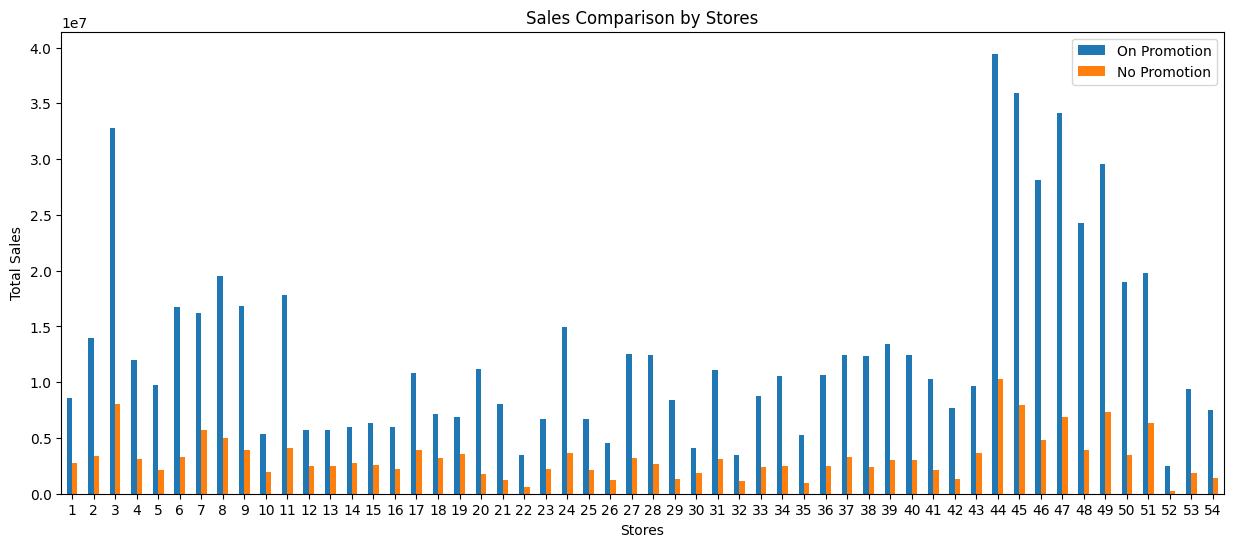

All stores experienced significant increase in sales when products are promoted


In [66]:
# Group product family by onpromotion or no promotion
onpromo_stores = all_promotions.groupby(by='store_nbr').sales.sum().sort_values(ascending=False)
nopromo_stores = no_promotions.groupby(by='store_nbr').sales.sum().sort_values(ascending=False)

# Create a DataFrame for plotting
store_promo_df = pd.DataFrame({
    'On Promotion': onpromo_stores,
    'No Promotion': nopromo_stores})

# Plotting
store_promo_df.plot(kind='bar', figsize=(15, 6))
plt.title('Sales Comparison by Stores')
plt.xlabel('Stores')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.legend(loc='best')
plt.show()

# =================================================================

# Calculate the difference in sale by products when promoted and when not
promo_diff_store = store_promo_df['On Promotion'] - store_promo_df['No Promotion']

# Print
print(f'All stores experienced significant increase in sales when products are promoted')


__Observations__
- All stores sales were positively affected by promotion.

##### 9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

### Step 4: Modeling and Evauation

#### Data Preparation

Use all_df

In [67]:
# Assuming the index of train_df is a datetime index
train_df['day_of_month'] = train_df.index.day
train_df['week_of_year'] = train_df.index.isocalendar().week
train_df['day_of_the_year'] = train_df.index.dayofyear
train_df['quarter'] = train_df.index.quarter

# Reset the index
train_df = train_df.reset_index()

# Merge the train_df with transaction_df on date and store_nbr
train_merge = pd.merge(train_df, transactions_df, on=['date', 'store_nbr'], how='left')
train_merge.head()


,date,id,store_nbr,family,sales,onpromotion,year,month,month_name,day,day_name,day_of_month,week_of_year,day_of_the_year,quarter,transactions
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,2013,1,January,1,Tuesday,1,1,1,1,NaN
1,2013-01-01,1,1,BABY CARE,0.0,0,2013,1,January,1,Tuesday,1,1,1,1,NaN
2,2013-01-01,2,1,BEAUTY,0.0,0,2013,1,January,1,Tuesday,1,1,1,1,NaN
3,2013-01-01,3,1,BEVERAGES,0.0,0,2013,1,January,1,Tuesday,1,1,1,1,NaN
4,2013-01-01,4,1,BOOKS,0.0,0,2013,1,January,1,Tuesday,1,1,1,1,NaN


Since "transactions" had a high correlation with "sales" we will merge the transaction and the train data.

In [68]:
# Check for nulls
train_merge.isna().sum()

date                    0
id                      0
store_nbr               0
family                  0
sales                   0
onpromotion             0
year                    0
month                   0
month_name              0
day                     0
day_name                0
day_of_month            0
week_of_year            0
day_of_the_year         0
quarter                 0
transactions       245784
dtype: int64

In [71]:
# Fill null values in 'transactions' with zero where 'sales' is zero
train_merge['transactions'] = np.where(train_merge['sales'] == 0, 0, train_merge['transactions'])

train_merge.isna().sum()

date                  0
id                    0
store_nbr             0
family                0
sales                 0
onpromotion           0
year                  0
month                 0
month_name            0
day                   0
day_name              0
day_of_month          0
week_of_year          0
day_of_the_year       0
quarter               0
transactions       3248
dtype: int64

We filled all the transactions that had "0" sales with "0" value which significantly reduced the null values. The rest of the nulls will be handled in the pipeline

In [72]:
# Select the features for X
X = train_df.drop(columns=['sales', 'id', 'date', 'month_name', 'day_name'], axis=1)

# Define the training and testing years
train_years = [2013, 2014, 2015, 2016]
test_year = [2017]

# Split the features and target into train and test sets
X_train = X[X['year'].isin(train_years)]
X_test = X[X['year'].isin(test_year)]
y_train = train_df[train_df['year'].isin(train_years)]['sales']
y_test = train_df[train_df['year'].isin(test_year)]['sales']

# Group the features
categorical_columns = X.select_dtypes(include=['object', 'bool']).columns
numeric_columns = X.select_dtypes(include='number').columns

(X_train.shape, y_train.shape) , (X_test.shape, y_test.shape)


(((2596374, 10), (2596374,)), ((404514, 10), (404514,)))

We initially extracted multiple features from the date index for modelling, Then we split them into train and test using the years.


Encoding (Scaling) y

In [73]:
# Initialize the scaler
scaler = RobustScaler()

# Encode y (scaling)(reshape y with".reshape(-1,1)" to 2D array for scaling and convert back to 1D with "flatten()")
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).flatten()


Create a Pipeline

In [74]:
# Define preprocessing steps for categorical and numerical features
categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('onehot', OneHotEncoder())
])

numeric_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', RobustScaler())
])

# Combine the preprocessing steps into a single transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_preprocessor, numeric_columns),
        ('cat', categorical_preprocessor, categorical_columns)
    ]
)

#### Models

##### Baseline Model

In [72]:
# Baseline Model
y_pred_baseline = np.full_like(y_test_scaled, y_train_scaled.mean())

# Calculate metrics
mse_baseline = mean_squared_error(y_test_scaled, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test_scaled, y_pred_baseline)
mape_baseline = np.mean(np.abs((y_test_scaled - y_pred_baseline) / y_test_scaled)) * 100
r2_baseline = r2_score(y_test_scaled, y_pred_baseline)

# Print Metrics
print("Baseline Model")
print(f'MSE: {mse_baseline:.2f}')
print(f'RMSE: {rmse_baseline:.2f}')
print(f'MAE: {mae_baseline:.2f}')
print(f'MAPE: {mape_baseline:.2f}')
print(f'r2: {r2_baseline:.2f}')


Baseline Model
MSE: 54.80
RMSE: 7.40
MAE: 3.19
MAPE: inf
r2: -0.01


##### Linear Regression

In [73]:
# Create a pipeline that includes the preprocessor and a model
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())  # Replace with your model
])

# Fit the pipeline on the training data
lr_pipeline.fit(X_train, y_train_scaled)

# Predict on the test set
y_pred_lr = lr_pipeline.predict(X_test)

# Calculate metrics
mse_lr = mean_squared_error(y_test_scaled, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test_scaled, y_pred_lr)
mape_lr = np.mean(np.abs((y_test_scaled - y_pred_lr) / y_test_scaled)) * 100
r2_lr = r2_score(y_test_scaled, y_pred_lr)

# Create a DataFrame to store results for Random Forest
results_lr = pd.DataFrame({'Model': ['Linear Regression'],
                            'R2': [r2_lr],
                            'RMSE': [rmse_lr],
                            'MSE': [mse_lr],
                            'MAE': [mae_lr],
                            'MAPE': [mape_lr]}).round(2)

# Print the results_rf dataframe
results_lr

,Model,R2,RMSE,MSE,MAE,MAPE
0,Linear Regression,0.58,4.77,22.73,1.77,inf


##### Support Vector Regression

In [74]:
# # Create a pipeline that includes the preprocessor and a model
# svr_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('PCA', PCA(n_components=2)),
#     ('model', SVR(kernel='linear'))
# ])

# # Fit the pipeline on the training data
# svr_pipeline.fit(X_train, y_train_scaled)

# # Predict on the test set
# y_pred_svr = svr_pipeline.predict(X_test)

# # Metrics
# mse_svr = mean_squared_error(y_test, y_pred_svr)
# rmse_svr = np.sqrt(mse_svr)
# mae_svr = mean_absolute_error(y_test, y_pred_svr)
# mape_svr = np.mean(np.abs((y_test - y_pred_svr) / y_test)) * 100
# r2_svr = r2_score(y_test, y_pred_svr)

# # Print results
# print("Support Vector Regression Model")
# print(f'MSE: {mse_svr:.2f}')
# print(f'RMSE: {rmse_svr:.2f}')
# print(f'MAE: {mae_svr:.2f}')
# print(f'MAPE: {mape_svr:.2f}')
# print(f'r2: {r2_svr:.2f}')

# # Create a DataFrame to store results for Random Forest
# results_svr = pd.DataFrame({'Model': ['SVR'],
#                             'R2': [r2_svr],
#                             'RMSE': [rmse_svr],
#                             'MSE': [mse_svr],
#                             'MAE': [mae_svr],
#                             'MAPE': [mape_svr]}).round(2)

# # Print the results_rf dataframe
# results_svr



The runtime is too long because of the Onehot encoding creating multiple columns thereby increasing the dimensionality of the dataset

##### Random Forest Regression

In [75]:
# Create a pipeline that includes the preprocessor and a model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('PCA', PCA(n_components=2)),
    ('model', RandomForestRegressor(random_state=42))
])

# Fit the pipeline on the training data
rf_pipeline.fit(X_train, y_train_scaled)

# Predict on the test set
y_pred_rf = rf_pipeline.predict(X_test)

# Metrics
mse_rf = mean_squared_error(y_test_scaled, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test_scaled, y_pred_rf)
mape_rf = np.mean(np.abs((y_test_scaled - y_pred_rf) / y_test_scaled)) * 100
r2_rf = r2_score(y_test_scaled, y_pred_rf)

# # Print results
# print("Support Vector Regression Model")
# print(f'MSE: {mse_rf:.2f}')
# print(f'RMSE: {rmse_rf:.2f}')
# print(f'MAE: {mae_rf:.2f}')
# print(f'MAPE: {mape_rf:.2f}')
# print(f'r2: {r2_rf:.2f}')

# Create a DataFrame to store results for Random Forest
results_rfr = pd.DataFrame({'Model': ['SVR'],
                            'R2': [r2_rf],
                            'RMSE': [rmse_rf],
                            'MSE': [mse_rf],
                            'MAE': [mae_rf],
                            'MAPE': [mape_rf]}).round(2)

# Print the results_rf dataframe
results_rfr


,Model,R2,RMSE,MSE,MAE,MAPE
0,SVR,-1.46,11.56,133.59,7.79,inf


##### Arima

In [78]:
# Define ARIMA parameters
# p (AutoRegressive order):
# The number of lag observations (past values) to include in the model.
p = 1       # Setting p = 1 means the model will use the value from the previous time point to predict the current value.

# d (Differencing order):
# The number of times the raw observations are differenced to make the time series stationary.
d = 0       # Setting d = 0 means no differencing is applied, implying that the time series data is already stationary.

# q (Moving Average order):
# The number of lagged forecast errors to include in the model.
q = 0       # Setting q = 0 means the model does not use past forecast errors.

class ARIMAModel:
    def __init__(self, order):
        self.order = order
        self.model = None
    
    def fit(self, X, y):
        # Convert to dense array if X is a sparse matrix
        if hasattr(X, "toarray"):
            X = X.toarray()
        if hasattr(y, "toarray"):
            y = y.toarray()
        self.model = ARIMA(y, order=self.order).fit()
        return self
    
    def predict(self, X):
        # Convert to dense array if X is a sparse matrix
        if hasattr(X, "toarray"):
            X = X.toarray()
        return self.model.forecast(steps=len(X))

# Create a pipeline that includes the preprocessor and the ARIMA model
arima_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ARIMAModel(order=(p, d, q)))
])

# Fit the model to the training data
arima_pipeline.fit(X_train, y_train_scaled)

# Predict on the test set
y_pred_arima = arima_pipeline.predict(X_test)

# Calculate metrics
mse_arima = mean_squared_error(y_test_scaled, y_pred_arima)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(y_test_scaled, y_pred_arima)
mape_arima = np.mean(np.abs((y_test_scaled - y_pred_arima) / y_test_scaled)) * 100
r2_arima = r2_score(y_test_scaled, y_pred_arima)

# Create a DataFrame to store results for ARIMA
results_arima = pd.DataFrame({'Model': ['ARIMA Model'],
                              'R2': [r2_arima],
                              'RMSE': [rmse_arima],
                              'MSE': [mse_arima],
                              'MAE': [mae_arima],
                              'MAPE': [mape_arima]}).round(2)

# Print the results_arima dataframe
print(results_arima)


         Model    R2  RMSE   MSE   MAE  MAPE
0  ARIMA Model -0.01   7.4  54.8  3.19   inf


##### Sarima Model


In [81]:
# Define SARIMA parameters
p = 1
d = 0
q = 0

# Set the order and seasonal order parameters
P = 0       # Seasonal autoregressive order
D = 0       # Seasonal differencing order
Q = 0       # Seasonal moving average order
s = 12      # Seasonal period (chosen based on the number of months each year)

class SARIMAModel:
    def __init__(self, order, seasonal_order):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None
    
    def fit(self, X, y):
        # Convert to dense array if X is a sparse matrix
        if hasattr(X, "toarray"):
            X = X.toarray()
        if hasattr(y, "toarray"):
            y = y.toarray()
        self.model = SARIMAX(endog=y, exog=X, order=self.order, seasonal_order=self.seasonal_order).fit()
        return self
    
    def predict(self, X):
        # Convert to dense array if X is a sparse matrix
        if hasattr(X, "toarray"):
            X = X.toarray()
        return self.model.forecast(steps=len(X), exog=X)

# Create a pipeline that includes the preprocessor and the SARIMA model
sarima_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SARIMAModel(order=(p, d, q), seasonal_order=(P, D, Q, s)))
])

# Fit the model to the training data
sarima_pipeline.fit(X_train, y_train_scaled)

# Predict on the test set
y_pred_sarima = sarima_pipeline.predict(X_test)

# Calculate metrics
mse_sarima = mean_squared_error(y_test_scaled, y_pred_sarima)
rmse_sarima = np.sqrt(mse_sarima)
mae_sarima = mean_absolute_error(y_test_scaled, y_pred_sarima)
mape_sarima = np.mean(np.abs((y_test_scaled - y_pred_sarima) / y_test_scaled)) * 100
r2_sarima = r2_score(y_test_scaled, y_pred_sarima)

# Create a DataFrame to store results for SARIMA
results_sarima = pd.DataFrame({'Model': ['SARIMA Model'],
                              'R2': [r2_sarima],
                              'RMSE': [rmse_sarima],
                              'MSE': [mse_sarima],
                              'MAE': [mae_sarima],
                              'MAPE': [mape_sarima]}).round(2)

# Print the results_sarima dataframe
print(results_sarima)


KeyboardInterrupt: 